In this notebook, I examine the provided data for Kaggle's Humpback Whale ID challenge. I also look at data augmentations in an attempt to inflate the size of the training dataset.

In [1]:
import math
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import sys
import shutil
import random
import imageio

from six.moves import cPickle as pickle

from tqdm import tqdm

%matplotlib inline

In [2]:
import zipfile as zp

path_to_file='../data/train.zip'
directory_to_extract='../data/train_images'
zip_ref = zp.ZipFile(path_to_file, 'r')
zip_ref.extractall(directory_to_extract)
zip_ref.close()

In [2]:
INPUT_DIR = '../data/train_images/train/'

In [12]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(INPUT_DIR+filename) for filename in filenames]
    
    return plot_images(imgs, labels, rows)

def plot_images_in_dir(filenames, labels, directory='', rows=4):
    imgs = [plt.imread(directory+'/'+filename) for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(13, 8))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

In [13]:
np.random.seed(42)

## Exploring the dataset

In [14]:
train_df = pd.read_csv('../data/train.csv')
train_df.head(10)

Image         Id
0  00022e1a.jpg  w_e15442c
1  000466c4.jpg  w_1287fbc
2  00087b01.jpg  w_da2efe0
3  001296d5.jpg  w_19e5482
4  0014cfdf.jpg  w_f22f3e3
5  0025e8c2.jpg  w_8b1ca89
6  0026a8ab.jpg  w_eaad6a8
7  0031c258.jpg  new_whale
8  0035632e.jpg  w_3d0bc7a
9  0037e7d3.jpg  w_50db782

Let's plot a couple of images at random.

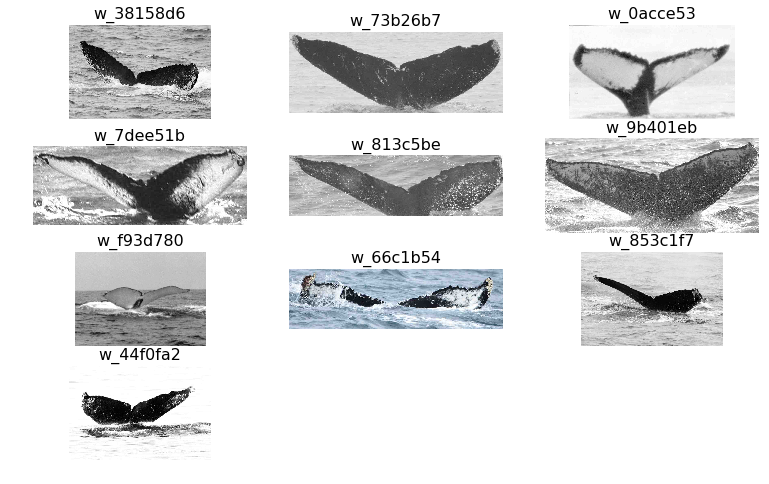

In [15]:
rand_rows = train_df.sample(frac=1.)[:10]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

The competition states that it's hard because: "there are only a few examples for each of 3,000+ whale ids", so let's take a look at the breakdown of number of image per category.

In [16]:
num_categories = len(train_df['Id'].unique())
     
print('Number of categories: '+str(num_categories))

Number of categories: 4251


There appear to be too many categories to graph count by category, so let's instead graph the number of categories by the number of images in the category.

In [17]:
size_buckets = Counter(train_df['Id'].value_counts().values)

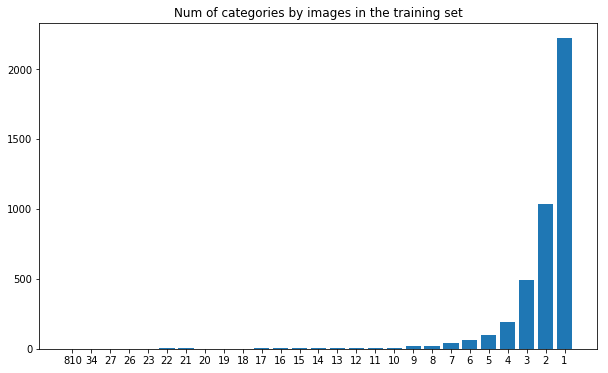

In [18]:
plt.figure(figsize=(10, 6))

plt.bar(range(len(size_buckets)), list(size_buckets.values())[::-1], align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys())[::-1])
plt.title("Num of categories by images in the training set")

plt.show()

As we can see, the vast majority of classes only have a single image in them. This is going to make predictions very difficult for most conventional image classification models.

In [19]:
train_df['Id'].value_counts().head(20)

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
w_693c9ee     22
w_fd1cb9d     22
w_ab4cae2     22
w_43be268     21
w_73d5489     21
w_987a36f     21
w_f19faeb     20
w_9b401eb     19
w_95874a5     19
w_c0d494d     18
w_b7d5069     18
w_dbda0d6     17
w_0e737d0     17
w_eb0a6ed     17
w_18eee6e     17
Name: Id, dtype: int64

In [20]:
total = len(train_df['Id'])
print('Total images in training set '+str(total))

Total images in training set 9850


New whale is the biggest category with 810, followed by `w_1287fbc`. New whale, I believe, is any whale that isn't in scientist's database. Since we can pick 5 potential labels per id, it's probably going to make sense to always include new_whale in our prediction set, since there's always an 8.2% change that's the right one. Let's take a look at one of the classes, to get a sense what flute looks like from the same whale.

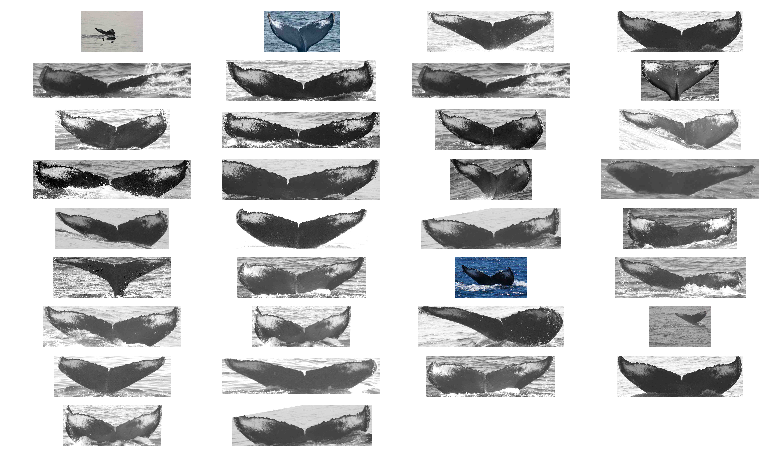

In [21]:
w_1287fbc = train_df[train_df['Id'] == 'w_1287fbc']
plot_images_for_filenames(list(w_1287fbc['Image']), None, rows=9)

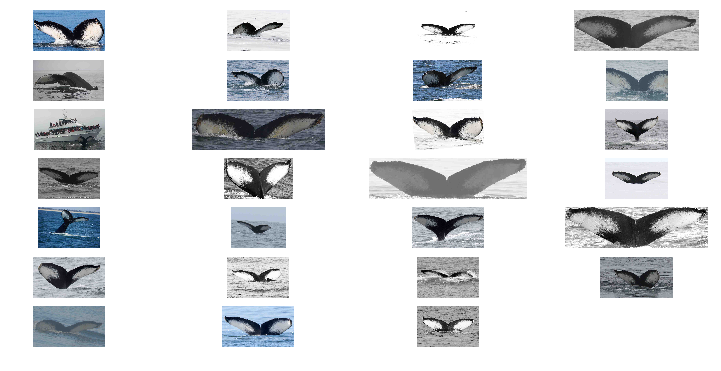

In [22]:
w_98baff9 = train_df[train_df['Id'] == 'w_98baff9']
plot_images_for_filenames(list(w_98baff9['Image']), None, rows=9)

It's very difficult to build a validation set when most classes only have 1 image, so my thinking is to perform some aggressive data augmentation on the classes with < 10 images before creating a train/validation split. Let's take a look at a few examples of whales with only one example.

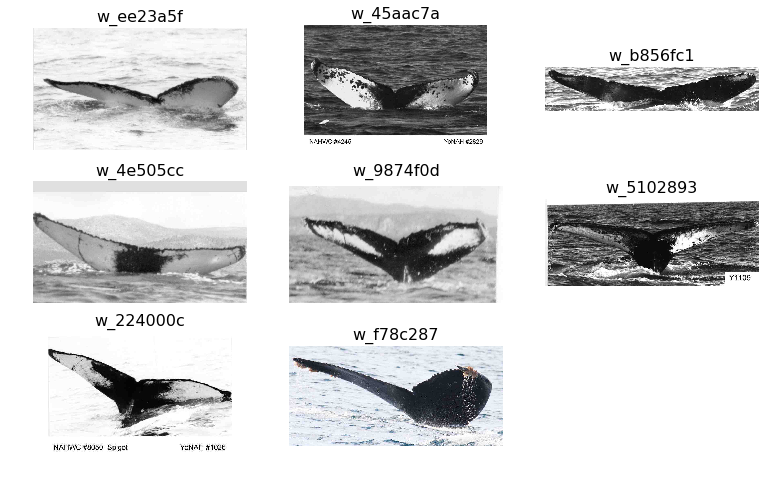

In [23]:
one_image_ids = train_df['Id'].value_counts().tail(8).keys()
one_image_filenames = []
labels = []
for i in one_image_ids:
    one_image_filenames.extend(list(train_df[train_df['Id'] == i]['Image']))
    labels.append(i)
    
plot_images_for_filenames(one_image_filenames, labels, rows=3)

From these small sample sizes, it seems like > 50% of images are black and white, suggesting that a good initial augementation might be to just convert colour images to greyscale and add to the training set. Let's confirm that by looking at a sample of the images.

In [24]:
def is_grey_scale(img_path):
    """Thanks to https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli"""
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

In [25]:
is_grey = [is_grey_scale(INPUT_DIR+str(i)) for i in train_df['Image'].sample(frac=0.1)]
grey_perc = round(sum([i for i in is_grey]) / len([i for i in is_grey]) * 100, 2)
print(' of grey images: '+grey_perc)

KeyboardInterrupt: 

It might also be worth capturing the size of the images so we can get a sense of what we're dealing with.

In [ ]:
img_sizes = Counter([Image.open('{INPUT_DIR}/train/{i}').size for i in train_df['Image']])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")

plt.show()

## Data Augmentation 

In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

data_augment_path = '../data/dataAugment'

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

if not os.path.exists(data_augment_path):
    os.makedirs(data_augment_path)

img = load_img(INPUT_DIR+'/ff38054f.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
print('Image size: '+str(x.shape))
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=data_augment_path, save_prefix='whale', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Image size: (748, 1050, 3)


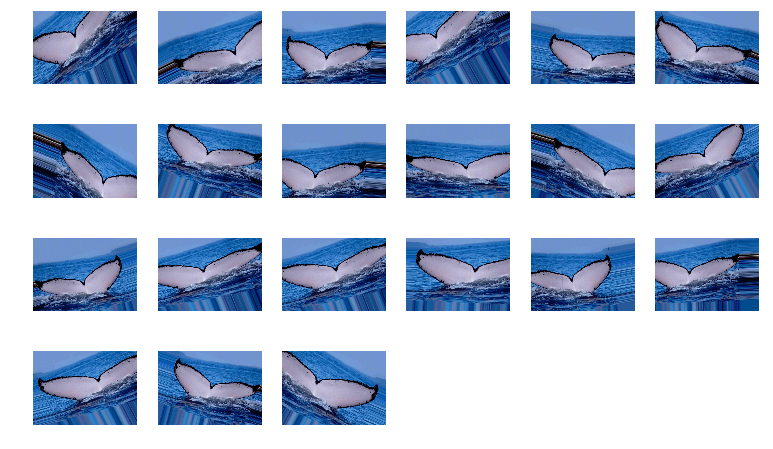

In [29]:
images = os.listdir('../data/dataAugment')

plot_images_in_dir(images, None, '../data/dataAugment', rows=4)

Now it is time to look at the image sizes

In [30]:
image_dir='../data/train_images/train'
train_images = os.listdir(image_dir)
height = []
width = []
print('Total number of images: '+str(len(train_images)))
img = load_img(image_dir+'/'+train_images[1])  # this is a PIL image
x = img_to_array(img) 
print(x.shape)
for image in train_images:
    img = load_img(image_dir+'/'+image)  # this is a PIL image
    x = img_to_array(img)
    height.append(x.shape[0])
    width.append(x.shape[1])
     

Total number of images: 9850
(700, 1050, 3)


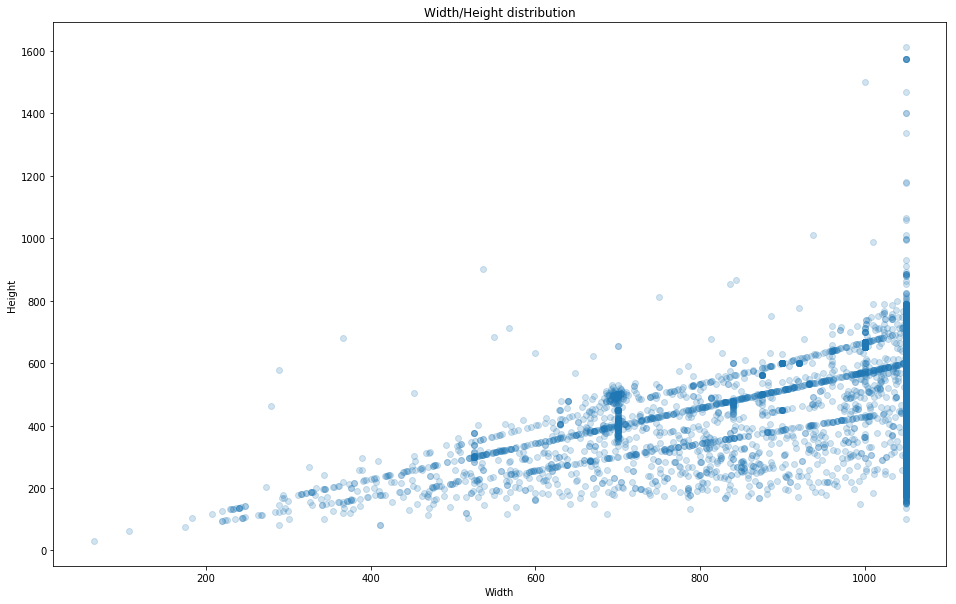

In [31]:
plt.figure(figsize=(16, 10))
plt.title('Width/Height distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.scatter(width, height, alpha=.2)
plt.show()

### We are going to find out the average aspect ratio

The average aspect ratio is: 2.2622


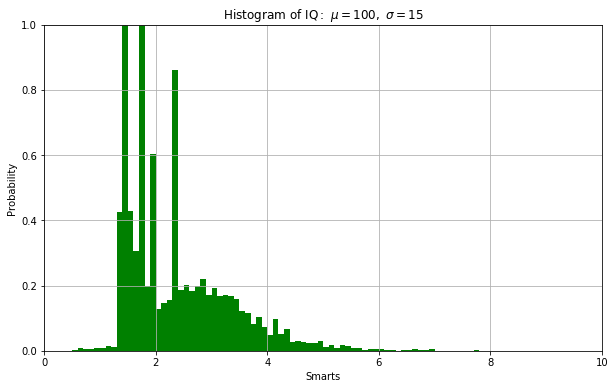

In [32]:
width = np.asarray(width, dtype=np.float32)
height = np.asarray(height, dtype=np.float32)
aspectratio = width/height
print('The average aspect ratio is: '+str(np.mean(aspectratio)))

plt.figure(figsize=(10, 6))

# the histogram of the data
n, bins, patches = plt.hist(aspectratio, 100, normed=1, facecolor='green')

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.axis([0, 10, 0, 1])
plt.grid(True)

plt.show()

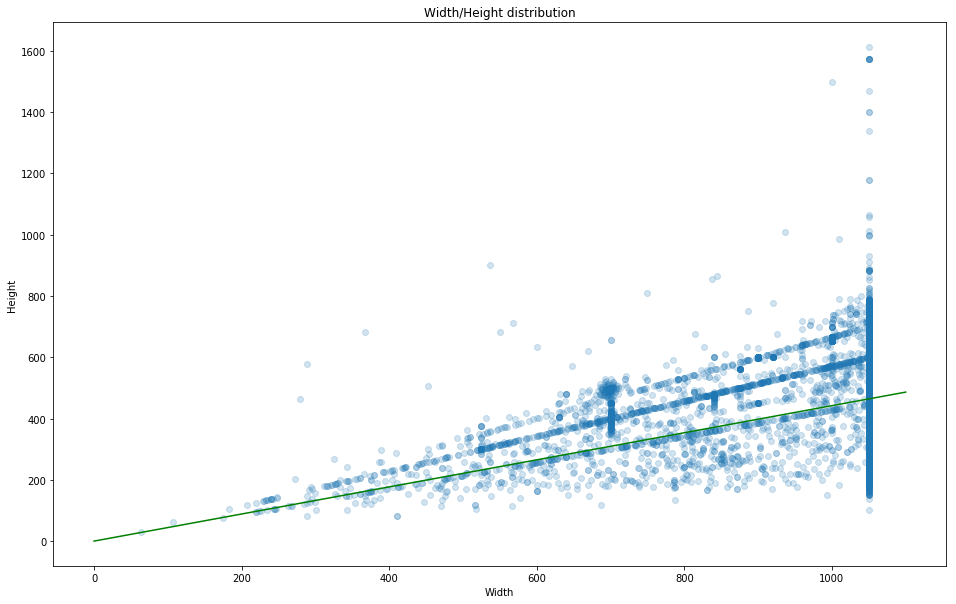

In [33]:
plt.figure(figsize=(16, 10))
plt.title('Width/Height distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.scatter(width, height, alpha=.2)
line_x_range = (0, 1100)
plt.plot(line_x_range, [ a * 1/np.mean(aspectratio) for a in line_x_range], "g", alpha=1)
plt.show()

In [34]:
def compute_pairs(n):
    pairs = 0
    for pair in range(1,n-1):
        pairs += pair
        
    return pairs

pictures_in_class = 15
print('For '+str(pictures_in_class)+' pictures in class there are '+str(compute_pairs(pictures_in_class))+' pairs.')

For 15 pictures in class there are 91 pairs.


In [36]:
#Create ordered test folder
newpath = '../data/train_ordered'
if not os.path.exists(newpath):
    os.makedirs(newpath)
# Creating a folder for each whale id
#New folder names set
folder_ids = set(train_df['Id'].values.tolist())
for folder_id in folder_ids:
    new_path_folder = newpath+'/'+folder_id
    if not os.path.exists(new_path_folder):
        os.makedirs(new_path_folder)
    images = train_df[train_df['Id'] == folder_id]['Image'].values.tolist()
    for image in images:
        full_file_name = os.path.join('../data/train_images/train', image)
        if (os.path.isfile(full_file_name)):
            shutil.copy(full_file_name, new_path_folder)

In [6]:
newpath = '../data/train_ordered'
source_dir = '../data/train_images/train'

def copy_images_to_dir(images, source_dir, destination_dir, maximum=0):
    for index, image in enumerate(images):
            full_file_name = os.path.join(source_dir, image)
            if (os.path.isfile(full_file_name)):
                shutil.copy(full_file_name, destination_dir)
            if (maximum != 0) and index >= maximum-1:
                return
            
def copy_images_to_dir_expand(images, source_dir, destination_dir, maximum=0, minimum=0):
    copy_images_to_dir(images, source_dir, destination_dir, maximum)
    if minimum != 0 and len(images) < minimum:
        for index in range(1,minimum - len(images)):
            image_ex = load_img(os.path.join(source_dir, random.choice(images)))  # this is a PIL image
            x = img_to_array(image_ex)  # this is a Numpy array with shape (3, 150, 150)
            x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=destination_dir, save_prefix='exp_', save_format='jpeg'):
                break  # otherwise the generator would loop indefinitely
                    
def generate_file_structure(root_path, source_dir=None, maximum=0, minimum=0):
    progress = 0
    print('Progress '+str(progress)+' %')
    if not os.path.exists(root_path):
        os.makedirs(root_path)
    # Creating a folder for each whale id
    #New folder names set
    folder_ids = set(train_df['Id'].values.tolist())
    for index, folder_id in enumerate(folder_ids):
        new_path_folder = os.path.join(root_path, folder_id)
        if not os.path.exists(new_path_folder):
            os.makedirs(new_path_folder)
        if source_dir is not None:
            images = train_df[train_df['Id'] == folder_id]['Image'].values.tolist()
            copy_images_to_dir_expand(images, source_dir, new_path_folder, maximum, minimum)
        if(round(100*float(index)/float(len(folder_ids))) > progress):
            print('Progress '+str(round(100*float(index)/float(len(folder_ids))))+' %')
        progress = round(100*float(index)/float(len(folder_ids)))

### Conversion from RBG to Greyscale
The following function will take an image and, if it is in RGB, will aplly a conversion from RGB to greyscale

In [9]:
#Weights RGB used for image convesion to greyscale
R_WEIGHT = 0.299
G_WEIGHT = 0.587
B_WEIGHT = 0.114
#Target size in pixels for reshape
DATASET_HEIGHT = 44
DATASET_WIDTH = 100

In [10]:
#input is a file path that should point to an image file.
#output is the Greyscale version of that image.
def convert_image_to_greyscale(image_path, verbose = False):
    #Read image from given filepath and also print its shape for information
    image = imageio.imread(image_path)
    if verbose:
        print("Image shape = {}".format(image.shape))
    
    # init 2D numpy array thay will contained the greyscale image to return
    grey = np.zeros((image.shape[0], image.shape[1])) 
    
    #detect if provided image is already in greysaale (Assumption is that there is only one 
    #layer, so shape[2] not existent). If so, return the input as output.
    if len(image.shape) < 3 :
        if verbose:
            print("Image {} is already in Greyscale.".format(image_path) )
        return image
    #If image shape[2] is 3 (asume RGB) we will convert it to gresycale. If shape[2] exists but reports 1
    # then we detect it and return the input image as an output.
    # if shape[2] its not 3 nor 1 we will raise an exception due to invalid value
    try:
        assert( image.shape[2] == 3 )
        assert( 1.01 > (R_WEIGHT + G_WEIGHT + B_WEIGHT) > 0.99 ) #Ensure weights are valid, they add up to 1.0
        grey = R_WEIGHT * image[:,:, 0] + G_WEIGHT * image[:,:, 1] + B_WEIGHT * image[:,:, 2]
    except AssertionError:
        if image.shape[2] == 1:
            if verbose:
                print("Image {} is already in Greyscale.".format(image_path) )
            grey = image
        else:
            raise ValueError("Image {} is not in RGB format nor in Greyscale. It has {} layers. Please \
              double check.".format(image_path, image.shape[2]))
    return grey

#### Resize image to desried size
The following function will take a np vector representing a greyscale image and resize it to a desired size.

For Resample:
- Image.NEAREST (use nearest neighbour)
- Image.BILINEAR (linear interpolation) 
- Image.BICUBIC (cubic spline interpolation)
- Image.LANCZOS (a high-quality downsampling filter)
If omitted, or if the image has mode “1” or “P”, it is set PIL.Image.NEAREST.

In [11]:
#input a greyscale np representing an image
#output a greyscale np representing theinput image rechaped to different dimensions
def resize_image(image_np):
    _img = Image.fromarray(image_np) 
    _img = _img.resize( (DATASET_WIDTH , DATASET_HEIGHT) , Image.BILINEAR )
    assert(_img.size[0] == DATASET_WIDTH)
    assert(_img.size[1] == DATASET_HEIGHT)
    return np.array(_img.getdata(), np.uint8).reshape(_img.size[1], _img.size[0])
    

Let's test the functions resize_image and convert_image_to_greyscale

Converting image ../data/train_balanced/w_deb33de/exp__0_1148.jpeg :


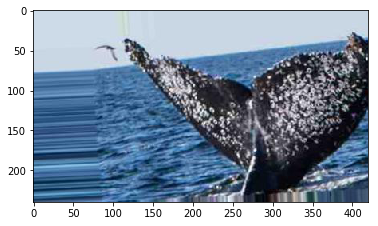

Image shape = (240, 420, 3)


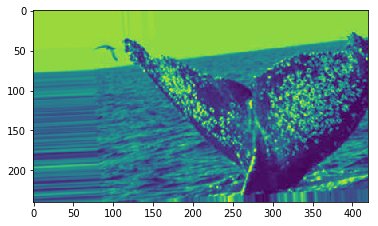

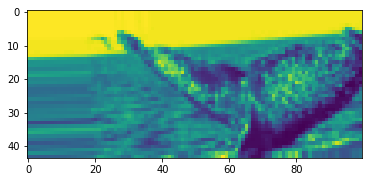

(44, 100)


In [12]:
path = "../data/train_balanced/w_deb33de/"
im_file = path + random.choice(os.listdir(path))
print("Converting image {} :".format(im_file))

image = imageio.imread(im_file)
plt.imshow(image) #load
plt.show() 

image_grey = convert_image_to_greyscale(im_file, True)
_image_grey = Image.fromarray(image_grey)
_image_grey.show()
plt.imshow(image_grey) #load
plt.show() 

image_final = resize_image(image_grey)
_image_final = Image.fromarray(image_final)
_image_final.show()
plt.imshow(image_final) #load
plt.show() 
print(image_final.shape)

In [13]:
print(train_df['Id'].values.tolist()[50])
id_wale = train_df['Id'].values.tolist()[50]
#print(train_df)
print(train_df[train_df['Id'] == id_wale]['Image'].values.tolist())


NameError: name 'train_df' is not defined

# Data Processing

In [3]:
#Balance dataset
min_n_per_class = 0
max_n_per_class = 200
path_train_balanced = '../data/train_balanced'
source_dir = '../data/train_images/train'
#generate_file_structure(path_train_balanced, source_dir, max_n_per_class, min_n_per_class)

In [4]:
animals = ['dog', 'cat', 'elephant', 'pig']
print(len(animals))
print(random.choice(animals))
for index, animal in enumerate(animals):
    print('Animal number '+str(index)+' is '+animal)

4
elephant
Animal number 0 is dog
Animal number 1 is cat
Animal number 2 is elephant
Animal number 3 is pig


#### Whale_id.pckle creation
Lets iterate through all folders to transform images and save pickle for later use

In [16]:
#Input: np to pickle
#Actions: save input in a .pickle file in desired folder
#Output successful
def maybe_pickle(dest_dir, dataset, file_name, force=False):
    _success = True
    _msg = "No action"
    _set_filename = file_name + '.pickle'
    _file_path = os.path.join(dest_dir, _set_filename)
    if os.path.exists(_file_path) and not force:
        # You may override by setting force=True.
        _msg = '{} already present - Skipping pickling.'.format(_set_filename)
    else:
        try:
            with open(_file_path, 'wb') as f:
                pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
                _msg = "Success"
        except Exception as e:
            _msg = 'Unable to save data to {} : {}'.format(_set_filename, e)
            _success = False
    return _success, _msg
        
#Input: Root path where all subfolders are stored
#Actions: Reshape images and do pickle in every subfolder
def resize_and_pickle_images_in_dir(root_path, verbose = False):  
    _progress = 0
    _prev_progress = 0
    print("Progress {}%: ".format(_progress))
    #Make sure the path exist before executing the next steps.
    if not os.path.exists(root_path):
        raise ValueError("Path {} idoes not exist.".format(root_path) )
     
    # get all files' and folders' names in the current directory
    _filenames= os.listdir(root_path) 
    _sub_folders = []
    # loop through all the files and folders and check whether the current object is a folder or not
    for filename in _filenames: 
        _path = os.path.join(os.path.abspath(root_path), filename)
        # if it is a directory add it to subdirectories list
        if os.path.isdir(_path): 
            _sub_folders.append(_path)
    
    #Obtain number of subfolders for further checking and progress monitoring
    _total_folders = len(_sub_folders)
    
    #Loop through all subfolders
    for ix ,folder in enumerate(_sub_folders):
        _image_list = [f for f in os.listdir(folder) if (f.endswith('.jpg') or f.endswith('.jpeg'))]
        if verbose:
            print("In folder {} found {} images.".format( folder , len(_image_list)) )
            
        #Create empty np (intended) to store all processed image of a specific folder
        _image_concentrator = np.ndarray(shape = ( len(_image_list) , DATASET_HEIGHT, DATASET_WIDTH))
        #Loop through all images in a subfolder and reshape them. Save the reshaped in a np placeholder that will be saved in a pickle file
        for num, image_file in enumerate(_image_list):
            _image_path = os.path.join(os.path.abspath(folder), image_file)
            _image_concentrator[num , : , :] = resize_image( convert_image_to_greyscale(_image_path, verbose) ) 
            
        #Perform some checks before apply pickle
        assert(len(_image_list) == _image_concentrator.shape[0])
        
        #Output information
        if verbose:
            print("Reshaped and stored the {} images from folder {}".format( \
                                                    _image_concentrator.shape[2] , folder) )
        #Let's save the np as a .pickle:
        _success, _msg = maybe_pickle(folder, _image_concentrator,  os.path.basename(folder), force=False)
        if verbose:
            print("Pickle folder {} with message: ".format( folder) + _msg)
        #Now we make sure the operation was successful:
        if not _success:
            print("ERROR occurred in maybe_pickle: " + _msg)
        
        #Monitor Progress
        _progress = ((100 * ix /_total_folders)  )
        if ( _progress% 3 == 0) and (_progress > _prev_progress):
            _prev_progress = _progress
            print("Progress {}%".format( 100 * ix /_total_folders))
     
    ###REMEMBER TO NORMALIZE BEFORE PICKLE
    print("Progress 100%")    
    return

resize_and_pickle_images_in_dir(path_train_balanced , True)

Progress 0%: 
In folder /notebooks/humpbackwhale/data/train_balanced/w_54fc5b3 found 14 images.
Image shape = (624, 957, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (624, 957, 3)
Image shape = (624, 957, 3)
Image shape = (624, 957, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_54fc5b3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_54fc5b3 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_dfcf7fe found 14 images.
Image shape = (589, 1006, 3)
Image shape = (589, 1006, 3)
Image shape = (589, 1006, 3)
Image shape = (589, 1006, 3)
Image shape = (589, 1006, 3)
Image shape = (589, 1006, 3)
Image shape = (589, 1006, 3)
Image shape = (589, 1006

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (590, 885, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d20befa
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d20befa with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2cdf820 found 14 images.
Image shape = (333, 1050, 3)
Image shape = (288, 1050, 3)
Image shape = (333, 1050, 3)
Image shape = (288, 1050, 3)
Image shape = (333, 1050, 3)
Image shape = (288, 1050, 3)
Image shape = (288, 1050, 3)
Image shape = (288, 1050, 3)
Image shape = (333, 1050, 3)
Image shape = (333, 1050, 3)
Image shape = (288, 1050, 3)
Image shape = (288, 1050, 3)
Image shape = (288, 1050, 3)
Image shape = (288, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2cdf820
Pickle folder /

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_23e5a4c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_23e5a4c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f0612be found 14 images.
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Image shape = (237, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1905c66
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1905c66 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d47e2e3 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (352, 926, 3)
Image shape = (316, 543, 3)
Image shape = (352, 926, 3)
Image shape = (316, 543, 3)
Image shape = (316, 543, 3)
Image shape = (314, 508, 3)
Image shape = (600, 1050, 3)
Image shape = (352, 926, 3)
Image shape = (600, 1050, 3)
Image shape = (314, 508, 3)
Image sh

Image shape = (500, 876, 3)
Image shape = (500, 876, 3)
Image shape = (314, 525, 3)
Image shape = (256, 597, 3)
Image shape = (314, 525, 3)
Image shape = (500, 876, 3)
Image shape = (256, 597, 3)
Image shape = (500, 876, 3)
Image shape = (314, 525, 3)
Image shape = (256, 597, 3)
Image shape = (314, 525, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3aa2073
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3aa2073 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5dbe64d found 14 images.
Image shape = (282, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (221, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (221, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (221, 1050, 3)
Image shape = (221, 1050, 3)
Image shape = (221, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (282, 1050, 3)
Reshaped an

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b80d2cb
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b80d2cb with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_89f463f found 14 images.
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (348, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_89f463f
Pickle folder 

Image shape = (699, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (365, 886, 3)
Image shape = (250, 953, 3)
Image shape = (365, 886, 3)
Image shape = (591, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (365, 886, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (250, 953, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_883557a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_883557a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ca6a771 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image

Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Image shape = (321, 642, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_11138db
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_11138db with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3e1bdd0 found 14 images.
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_3e1bdd0/c36e7756.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Imag

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_62ec01b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_62ec01b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_84fcae8 found 14 images.
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)


Image shape = (343, 1050, 3)
Image shape = (449, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_900f9eb
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_900f9eb with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c48ad3e found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 i

Image shape = (407, 1050, 3)
Image shape = (407, 1050, 3)
Image shape = (407, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (407, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8507226
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8507226 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1c3e5da found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)


Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f68d0af
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f68d0af with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_32602d9 found 14 images.
Image shape = (530, 1012, 3)
Image shape = (530, 1012, 3)
Image shape = (530, 1012, 3)
Image shape = (530, 1012, 3)
Image shape = (530, 1012, 3)
Image shape = (530, 1012, 3)
Image shape = (530, 1012, 3)
Image shape = (530, 1012, 3)
Image shape = (530, 1012, 3)
Image shape = (530, 1012)
Image /notebooks/humpbackwhale/data/train_balanced/w_32602d9/1dc97b30.jpg is already in Greyscale.
Image shape = (530, 1012, 3)
Image shape = (530, 1012, 3)
Image shape = (530, 

Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Image shape = (656, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1698c29
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1698c29 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f10006a found 14 images.
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)
Image shape = (701, 1024, 3)


Image shape = (212, 1050, 3)
Image shape = (212, 1050, 3)
Image shape = (212, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_cf3a12e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_cf3a12e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3f43888 found 14 images.
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Image shape = (665, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3f43888
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3f43888 with message: Success
In folder /notebooks/humpbackwhale/data

Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e430ce0
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e430ce0 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0f96780 found 14 images.
Image shape = (591, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (666, 1000, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Reshaped and stored the 100 images from

Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Image shape = (532, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_56ccad1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_56ccad1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7417ab0 found 14 images.
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (321, 1050, 3)


Image shape = (267, 1050, 3)
Image shape = (267, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (267, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (267, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (267, 1050, 3)
Image shape = (267, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_eeb5fa7
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_eeb5fa7 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f5fd7ef found 14 images.
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape = (590, 885, 3)
Image shape 

Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_45e8ea5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_45e8ea5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_53f48f6 found 14 images.
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/

Image shape = (312, 996, 3)
Image shape = (371, 912, 3)
Image shape = (533, 1050, 3)
Image shape = (312, 996, 3)
Image shape = (232, 1050, 3)
Image shape = (393, 1050, 3)
Image shape = (362, 1050, 3)
Image shape = (312, 996, 3)
Image shape = (591, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ace8c54
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ace8c54 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d2e1f2a found 14 images.
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Image shape = (327, 808, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9b00e07
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9b00e07 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_91c0a1d found 14 images.
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)


Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a1114ee
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a1114ee with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c9566b4 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_c9566b4/c912ac66.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_76c2a95/57dca137.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_76c2a95
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_76c2a95 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b426ff3 found 14 images.
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Image shape = (548, 994, 3)
Im

Image shape = (713, 1000, 3)
Image shape = (713, 1000, 3)
Image shape = (713, 1000, 3)
Image shape = (713, 1000, 3)
Image shape = (713, 1000, 3)
Image shape = (713, 1000, 3)
Image shape = (713, 1000, 3)
Image shape = (713, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5d2734c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5d2734c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1c2fb13 found 14 images.
Image shape = (450, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_79581d3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_79581d3 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0899118 found 14 images.
Image shape = (481, 841, 3)
Image shape = (600, 1050, 3)
Image shape = (481, 841, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (481, 841, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (481, 841, 3)
Image shape = (481, 841, 3)
Image shape = (481, 841, 3)
Image shape = (600, 1050, 3)
Image shape = (481, 841, 3)
Reshaped and stored the 100 images f

Image shape = (150, 456, 3)
Image shape = (150, 456, 3)
Image shape = (150, 456, 3)
Image shape = (150, 456, 3)
Image shape = (150, 456, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7d2d70c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7d2d70c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_56743d6 found 14 images.
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (668, 1002, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (668, 1002, 3)
Image shape = (668, 1002, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (668, 1002, 3)
Image shape = (600, 900, 3)
Image shape = (668, 1002, 3)
Image shape = (668, 1002, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_56743d6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_56743d6 with message: Su

Image shape = (637, 1050, 3)
Image shape = (637, 1050, 3)
Image shape = (637, 1050, 3)
Image shape = (637, 1050, 3)
Image shape = (637, 1050, 3)
Image shape = (637, 1050, 3)
Image shape = (637, 1050, 3)
Image shape = (637, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ed67618
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ed67618 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_79b12d8 found 14 images.
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (333, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (333, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a687e28
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a687e28 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8309df3 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8309df3
Pickle folder 

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_373593e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_373593e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_fe8233d found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_fe8233d/1d5ed685.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b05f565
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b05f565 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_37f17ad found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)


Image shape = (788, 1050, 3)
Image shape = (312, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e5250e9
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e5250e9 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_aa3d7b8 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (490, 857, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (490, 857, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (490, 857, 3)
Image shape = (490, 857, 3)
Image shape = (490, 857, 3)
Image shape = (490, 857, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_aa3d7b8
Pickle folder /noteb

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2709cfc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2709cfc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e6ddbd5 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)


Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ba302c8
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ba302c8 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e88388a found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_e88388a/ba8a7124.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e88388a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e8

Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_cf69291
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_cf69291 with message: Success
Progress 9%
In folder /notebooks/humpbackwhale/data/train_balanced/w_52e7cf6 found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_52e7cf6/f6

Image shape = (456, 912, 3)
Image shape = (456, 912, 3)
Image shape = (456, 912, 3)
Image shape = (456, 912, 3)
Image shape = (456, 912, 3)
Image shape = (456, 912, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5f8c5d3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5f8c5d3 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_414c24a found 14 images.
Image shape = (401, 699, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_414c24a/28b13712.jpg is already in Greyscale.
Image shape = (401, 699, 3)
Image shape = (600, 1050, 3)
Image shape = (401, 699)
Image /notebooks/humpbackwhale/data/train_balanced/w_414c24a/786300a4.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (401, 699, 3)
Image shape = (600, 1050, 3)
Image shape = (401, 6

Image shape = (140, 496, 3)
Image shape = (243, 1050, 3)
Image shape = (140, 496, 3)
Image shape = (243, 1050, 3)
Image shape = (140, 496, 3)
Image shape = (243, 1050, 3)
Image shape = (243, 1050, 3)
Image shape = (140, 496, 3)
Image shape = (140, 496, 3)
Image shape = (140, 496, 3)
Image shape = (140, 496, 3)
Image shape = (140, 496, 3)
Image shape = (243, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_16f61aa
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_16f61aa with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f7fed13 found 14 images.
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image sh

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (460, 806, 3)
Image shape = (460, 806, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_02c2248
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_02c2248 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5384c57 found 14 images.
Image shape = (752, 1050, 3)
Image shape = (752, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (752, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (752, 1050, 3)
Image shape = (752, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (752, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5384c57
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5384c57 with 

Image shape = (513, 1050, 3)
Image shape = (513, 1050, 3)
Image shape = (513, 1050, 3)
Image shape = (261, 1050, 3)
Image shape = (513, 1050, 3)
Image shape = (261, 1050, 3)
Image shape = (513, 1050, 3)
Image shape = (513, 1050, 3)
Image shape = (328, 917, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_acc67ea
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_acc67ea with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_cddb3f4 found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_cddb3f4/c15de6e9.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0674604
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0674604 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_cce0444 found 14 images.
Image shape = (698, 1050, 3)
Image shape = (698, 1050, 3)
Image shape = (698, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (698, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (698, 1050, 3)
Image shape = (698, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (777, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (777, 1050, 3)
Image shape = (777, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e6f746e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e6f746e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f6d32e2 found 14 images.
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Image shape = (481, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f6d32e2
Pickle folder 

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6926f08
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6926f08 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d68d206 found 14 images.
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Image shape = (671, 1006, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0ffc383
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0ffc383 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5fcee47 found 14 images.
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Image shape = (447, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/

Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_12c3d3d/8087f977.jpg is already in Greyscale.
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_12c3d3d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_12c3d3d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_656afeb found 14 images.
Image shape = (700, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (578, 963, 3)
Image shape = (539, 900, 3)
Image shape = (539, 900, 3)
Image shape = (211, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (629, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (578, 963, 3)
Image shape = (211, 1050, 3)
Image shape = (630, 1050, 3)
Reshaped and stored the 

Image shape = (262, 879, 3)
Image shape = (262, 879, 3)
Image shape = (319, 1050, 3)
Image shape = (319, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ff70408
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ff70408 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_41901e5 found 14 images.
Image shape = (451, 902, 3)
Image shape = (451, 902, 3)
Image shape = (525, 1050, 3)
Image shape = (451, 902, 3)
Image shape = (525, 1050, 3)
Image shape = (451, 902, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (451, 902, 3)
Image shape = (525, 1050, 3)
Image shape = (451, 902, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_41901e5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_41901e5 with message: Success
In folder /noteboo

Image shape = (496, 866, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e8a9fb8
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e8a9fb8 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b80a9c5 found 14 images.
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Image shape = (182, 670, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b80a9c5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b80a9c5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3fffc61 found 14 images.
Image shape = (302, 1050, 3)
I

Image shape = (402, 703, 3)
Image shape = (402, 703, 3)
Image shape = (402, 703, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f33b12b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f33b12b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_a8494ea found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_a8494ea/e7b96ab9.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a8494ea
Pickle folder /notebooks/humpbackwhal

Image shape = (580, 1015, 3)
Image shape = (559, 979, 3)
Image shape = (559, 979, 3)
Image shape = (580, 1015, 3)
Image shape = (580, 1015, 3)
Image shape = (559, 979, 3)
Image shape = (559, 979, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_831f124
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_831f124 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7158e92 found 14 images.
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Image shape = (383, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7158e92
Pickle folder /not

Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1606afc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1606afc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_125ba17 found 14 images.
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_125ba17
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_125ba17 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_813c5be found 14 images.
Image shape = (5

Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_db93738/f6805ffa.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_db93738
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_db93738 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4659761 found 14 images.
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Reshaped and stored 

Image shape = (348, 522, 3)
Image shape = (600, 900, 3)
Image shape = (348, 522, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_acc33ca
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_acc33ca with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_408c5a7 found 14 images.
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Image shape = (356, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_408c5a7
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_408c5a7 with message: Success
In folder /notebooks/humpbackwhale/data/tr

Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_7fe3551/47841f63.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7fe3551
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7fe3551 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_480b2d4 found 14 images.
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (313, 548, 3)
Image shape = (313, 548, 3)
Image shape = (300, 525, 3)
Image shape = (313, 548, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (313, 548, 3)
Image shape = (313, 548, 3)
Image shape = (313, 548, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Reshaped and stored the 100 images from f

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1a4f16e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1a4f16e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3ca387d found 14 images.
Image shape = (384, 700, 3)
Image shape = (384, 700, 3)
Image shape = (384, 700, 3)
Image shape = (384, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_3ca387d/3a87043d.jpg is already in Greyscale.
Image shape = (384, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)

Image shape = (299, 699, 3)
Image shape = (497, 689)
Image /notebooks/humpbackwhale/data/train_balanced/w_3b99025/453e7bcb.jpg is already in Greyscale.
Image shape = (497, 689, 3)
Image shape = (299, 699, 3)
Image shape = (497, 689, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3b99025
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3b99025 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c26666e found 14 images.
Image shape = (400, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_c26666e/c397e521.jpg is already in Greyscale.
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_c26666e/117bb995.jpg is already in Greyscale.
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (40

Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_976a54b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_976a54b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_34942b2 found 14 images.
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_34942b2
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_34942b2 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2466659 found 14 images.
Image shape = (394, 690, 3)
Image shape = (3

Image shape = (241, 1050, 3)
Image shape = (241, 1050, 3)
Image shape = (241, 1050, 3)
Image shape = (241, 1050, 3)
Image shape = (241, 1050, 3)
Image shape = (241, 1050, 3)
Image shape = (241, 1050, 3)
Image shape = (241, 1050, 3)
Image shape = (241, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_216f61f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_216f61f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d8421c1 found 14 images.
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Image shape = (444, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2c1dafa
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2c1dafa with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5e04db0 found 14 images.
Image shape = (355, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (355, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (355, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (355, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (355, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (355, 1050, 3)
Image shape = (355, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5e04db0
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5e04db0 with message: Success
In folder /not

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4fa1bd5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4fa1bd5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_40cc259 found 14 images.
Image shape = (304, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)


Image shape = (508, 1050, 3)
Image shape = (508, 1050, 3)
Image shape = (508, 1050, 3)
Image shape = (284, 1050, 3)
Image shape = (284, 1050, 3)
Image shape = (284, 1050, 3)
Image shape = (284, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_979dc10
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_979dc10 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_69f4311 found 14 images.
Image shape = (289, 1050, 3)
Image shape = (310, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (310, 1050, 3)
Image shape = (310, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (310, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (310, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_69f4311
Pickle folder 

Image shape = (347, 1050, 3)
Image shape = (120, 366, 3)
Image shape = (347, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (347, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_cd70e8b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_cd70e8b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0ac6a0a found 14 images.
Image shape = (727, 1024)
Image /notebooks/humpbackwhale/data/train_balanced/w_0ac6a0a/5d3382ef.jpg is already in Greyscale.
Image shape = (727, 1024, 3)
Image shape = (392, 1050, 3)
Image shape = (392, 1050, 3)
Image shape = (727, 1024, 3)
Image shape = (392, 1050, 3)
Image shape = (392, 1050, 3)
Image shape = (392, 1050, 3)
Image shape = (392, 1050, 3)
Image shape = (392, 1050, 3)
Image shape = (392, 1050, 3)
Image shape = (392, 1050, 3)
Image shape = (392, 1

Image shape = (545, 1050, 3)
Image shape = (411, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (545, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_462a117
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_462a117 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f4224b9 found 14 images.
Image shape = (172, 439, 3)
Image shape = (172, 439, 3)
Image shape = (257, 502, 3)
Image shape = (534, 1050, 3)
Image shape = (534, 1050, 3)
Image shape = (534, 1050, 3)
Image shape = (257, 502, 3)
Image shape = (257, 502, 3)
Image shape = (534, 1050, 3)
Image shape = (172, 439, 3)
Image shape = (257, 502, 3)
Image shape = (257, 502, 3)
Image shape = (172, 439, 3)
Image shape = (257, 502, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f4224b9
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f4224b9 with message: Success
In folder /notebooks

Image shape = (416, 705)
Image /notebooks/humpbackwhale/data/train_balanced/w_c13a4e3/af7cbe5b.jpg is already in Greyscale.
Image shape = (416, 705, 3)
Image shape = (416, 705, 3)
Image shape = (416, 705, 3)
Image shape = (416, 705, 3)
Image shape = (416, 705, 3)
Image shape = (416, 705, 3)
Image shape = (187, 1050, 3)
Image shape = (187, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_c13a4e3/081ec076.jpg is already in Greyscale.
Image shape = (187, 1050, 3)
Image shape = (416, 705)
Image /notebooks/humpbackwhale/data/train_balanced/w_c13a4e3/0c64ae81.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c13a4e3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c13a4e3 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6e47e0e found 14 images.
Image shape = (385, 1050, 3)
Image shape = (385, 1050, 3)
Image shape = (385, 1050, 3)
Image shape = (484, 1050, 3)
Image shap

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_3cada3d/39beca9c.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3cada3d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3cada3d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_488f836 found 14 images.
Image shape = (754, 1050, 3)
Image shape = (754, 1050, 3)
Image shape = (754, 1050, 3)
Image shape = (754, 1050, 3)
Image shape = (754, 1050, 3)
Image shape = (754, 1050, 3)
Image shape = (754, 1050, 3)
Image shape = (754, 1050, 3)
Image shape = (754, 1050, 3)
Image shape = (754, 1050, 3)
Image shape = (754, 

Image shape = (465, 813, 3)
Image shape = (465, 813, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f4e84c1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f4e84c1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d10472d found 14 images.
Image shape = (301, 525, 3)
Image shape = (363, 630, 3)
Image shape = (363, 630, 3)
Image shape = (363, 630)
Image /notebooks/humpbackwhale/data/train_balanced/w_d10472d/4436a6a1.jpg is already in Greyscale.
Image shape = (301, 525, 3)
Image shape = (301, 525, 3)
Image shape = (301, 525, 3)
Image shape = (301, 525, 3)
Image shape = (363, 630, 3)
Image shape = (363, 630, 3)
Image shape = (301, 525)
Image /notebooks/humpbackwhale/data/train_balanced/w_d10472d/75316f27.jpg is already in Greyscale.
Image shape = (363, 630, 3)
Image shape = (363, 630, 3)
Image shape = (301, 525, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_ba

Image shape = (346, 606, 3)
Image shape = (346, 606, 3)
Image shape = (346, 606, 3)
Image shape = (605, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d8e752e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d8e752e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ffbd74c found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ffbd74c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ffbd74c with message: Success
In folder /no

Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Image shape = (548, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d94c323
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d94c323 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ec91e99 found 14 images.
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)


Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_43e45b6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_43e45b6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_9dab60c found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9dab60c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9dab60c with message: Success
In folder /notebooks/humpbackwhale/data

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_65943d6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_65943d6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_35ffe80 found 14 images.
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Reshaped and stored the 100 images from fol

Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6dc7db6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6dc7db6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_429e9ad found 14 images.
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Image shape = (304, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_429e9ad
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_429e9ad with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_200a203 found 14 images.
Image shape = (473, 828, 3)
Image shape = (4

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_6ec850b/4fbe587f.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6ec850b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6ec850b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_de20ab0 found 14 images.
Image shape = (542, 1050, 3)
Image shape = (542, 1050, 3)
Image shape = (542, 1050, 3)
Image shape = (542, 1050, 3)
Image shape = (542, 1050, 3)
Image shape = (542, 1050, 3)
Image shape = (542, 1050, 3)
Image shape = (542, 1050, 3)
Image shape = (542, 1050, 3)
Image shape = (542, 

Image shape = (402, 700, 3)
Image shape = (402, 700, 3)
Image shape = (402, 700, 3)
Image shape = (402, 700, 3)
Image shape = (402, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_b454f70/6f1998bf.jpg is already in Greyscale.
Image shape = (402, 700, 3)
Image shape = (402, 700, 3)
Image shape = (402, 700, 3)
Image shape = (402, 700, 3)
Image shape = (402, 700, 3)
Image shape = (402, 700, 3)
Image shape = (402, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b454f70
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b454f70 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0d2dc7e found 14 images.
Image shape = (501, 877, 3)
Image shape = (385, 674, 3)
Image shape = (501, 877, 3)
Image shape = (501, 877, 3)
Image shape = (501, 877, 3)
Image shape = (385, 674, 3)
Image shape = (385, 674, 3)
Image shape = (385, 674, 3)
Image shape = (385, 674, 3)
Image shape = (385, 674, 3)
Image shape =

Image shape = (666, 1000, 3)
Image shape = (666, 1000, 3)
Image shape = (666, 1000, 3)
Image shape = (666, 1000, 3)
Image shape = (666, 1000, 3)
Image shape = (666, 1000, 3)
Image shape = (666, 1000, 3)
Image shape = (666, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3076d8c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3076d8c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_42dd100 found 14 images.
Image shape = (363, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (366, 620, 3)
Image shape = (366, 620, 3)
Image shape = (366, 620, 3)
Image shape = (366, 620, 3)
Image shape = (363, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (366, 620, 3)
Image shape = (366, 620, 3)
Image shape = (363, 1050, 3)
Image shape = (366, 620)
Image /notebooks/humpbackwhale/data/train_balanced/w_42dd100/dcd0cfa6.jpg is already in Greyscale.
Image shape = (366, 620, 3)

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2282bb8
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2282bb8 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f178867 found 14 images.
Image shape = (444, 888, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (444, 888, 3)
Image shape = (525, 1050, 3)
Image shape = (444, 888, 3)
Image shape = (444, 888, 3)
Image shape = (444, 888, 3)
Image shape = (444, 888, 3)
Image shape = (525, 1050, 3)
Image shape = (444, 888, 3)
Image shape = (525, 1050, 3)
Image shape = (444, 888, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f178867
Pickle folder /noteboo

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_cc504e7
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_cc504e7 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b648329 found 14 images.
Image shape = (336, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (336, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (336, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (279, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (416, 1021, 3)
Image shape = (171, 1050, 3)
Image shape = (171, 1050, 3)
Image shape = (171, 1050, 3)
Image shape = (416, 1021, 3)
Image shape = (416, 1021, 3)
Image shape = (416, 1021, 3)
Image shape = (171, 1050, 3)
Image shape = (416, 1021, 3)
Image shape = (171, 1050, 3)
Image shape = (416, 1021, 3)
Image shape = (416, 1021, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5af463d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5af463d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3e9d82e found 14 images.
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (368, 1050, 3)


Image shape = (516, 1050, 3)
Image shape = (351, 709, 3)
Image shape = (351, 709, 3)
Image shape = (516, 1050, 3)
Image shape = (516, 1050, 3)
Image shape = (351, 709, 3)
Image shape = (516, 1050, 3)
Image shape = (516, 1050, 3)
Image shape = (516, 1050, 3)
Image shape = (351, 709, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_04c1951
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_04c1951 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6163581 found 14 images.
Image shape = (405, 700, 3)
Image shape = (405, 700, 3)
Image shape = (405, 700, 3)
Image shape = (405, 700, 3)
Image shape = (405, 700, 3)
Image shape = (405, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_6163581/4d11635e.jpg is already in Greyscale.
Image shape = (405, 700, 3)
Image shape = (405, 700, 3)
Image shape = (405, 700, 3)
Image shape = (405, 700, 3)
Image shape = (405, 700, 3)
Image shape = (405, 700, 3)
Image s

Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Image shape = (323, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_bbcafb8
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_bbcafb8 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8e451d9 found 14 images.
Image shape = (602, 1050, 3)
Image shape = (411, 954, 3)
Image shape = (396, 1050, 3)
Image shape = (602, 1050, 3)
Image shape = (396, 1050, 3)
Image shape = (602, 1050, 3)
Image shape = (602, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (396, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (396, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (411, 954, 3)
Im

Image shape = (269, 1050, 3)
Image shape = (199, 404, 3)
Image shape = (370, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (370, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (393, 1050, 3)
Image shape = (370, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (199, 404, 3)
Image shape = (199, 404, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3197568
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3197568 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_cae7677 found 15 images.
Image shape = (600, 1050, 3)
Image shape = (667, 1000, 3)
Image shape = (700, 1050, 3)
Image shape = (510, 1050, 3)
Image shape = (247, 782, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (449, 629, 3)
Image shape = (336, 739, 3)
Image shape = (667, 1000, 3)
Image shape = (511, 895, 3)
Image s

Image shape = (600, 900, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 900, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_24ad46c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_24ad46c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c0f3e88 found 14 images.
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (383, 894, 3)
Image shape = (450, 1050, 3)
Image shape = (474, 830, 3)
Image shape = (383, 894, 3)
Image shape = (383, 894, 3)
Image shape = (474, 830, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c0f3e88
Pickle folder /notebooks/humpbackwhale/data/train_ba

Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_afed305
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_afed305 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6e8486d found 14 images.
Image shape = (389, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (167, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (389, 1050, 3)
Image shape = (389, 1050, 3)
Image shape = (389, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (167, 1050, 3)
Image shape = (389, 1050, 3)
Image shape = (630, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6e8486d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6e8486d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8fb79a2 found 14 images.
Image shape = (404, 1000, 3)
Image shape = (

Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (326, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_aed6a9a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_aed6a9a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6aa5e66 found 14 images.
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Image shape = (522, 913, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6aa5e66
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6aa5e66 with message: Success
In folder /notebooks/hum

Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Image shape = (405, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_34c8690
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_34c8690 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_33032d1 found 14 images.
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_33032d1/d24f5d3c.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (532, 931, 3)
Image shape = (532, 931, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (532, 931, 3)
Image shape = (532, 931, 3)
Image shape = (532, 931, 3)
Image shape = (532, 931, 

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_16e3c6b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_16e3c6b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_788b689 found 14 images.
Image shape = (599, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_788b689
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_788b689 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f4b95e7 found

Image shape = (473, 1050, 3)
Image shape = (473, 1050, 3)
Image shape = (473, 1050, 3)
Image shape = (473, 1050, 3)
Image shape = (314, 1050, 3)
Image shape = (314, 1050, 3)
Image shape = (314, 1050, 3)
Image shape = (314, 1050, 3)
Image shape = (473, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1dc6d62
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1dc6d62 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c915956 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/

Image shape = (444, 888, 3)
Image shape = (444, 888, 3)
Image shape = (444, 888, 3)
Image shape = (444, 888, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_01a99a5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_01a99a5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c666071 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_c666071/4398e933.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c666071
Pickle fo

Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Image shape = (545, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_bc5beaa
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_bc5beaa with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_37bd99a found 14 images.
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape = (517, 904, 3)
Image shape 

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a5431ca
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a5431ca with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_136337c found 14 images.
Image shape = (675, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (675, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3d12652
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3d12652 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_660195e found 14 images.
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_660195e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_660195e with message: Success
In folder /notebooks/humpbackwhale/data

Image shape = (630, 939, 3)
Image shape = (328, 1050, 3)
Image shape = (748, 1041)
Image /notebooks/humpbackwhale/data/train_balanced/w_338b130/749ba78d.jpg is already in Greyscale.
Image shape = (328, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_338b130
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_338b130 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_39776da found 14 images.
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (289, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_39776da
Pickle

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (588, 1028, 3)
Image shape = (700, 1050, 3)
Image shape = (588, 1028, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (588, 1028, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_002222a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_002222a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f104523 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)


Image shape = (652, 1000, 3)
Image shape = (600, 1050, 3)
Image shape = (105, 244, 3)
Image shape = (652, 1000, 3)
Image shape = (105, 244, 3)
Image shape = (105, 244, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f438375
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f438375 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_36a853c found 14 images.
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_36a853c
Pickle folder /notebooks/humpbackwhale/data/tr

Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Image shape = (501, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_20da4cf
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_20da4cf with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_bbc4e7c found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)


Image shape = (298, 1050, 3)
Image shape = (298, 1050, 3)
Image shape = (298, 1050, 3)
Image shape = (298, 1050, 3)
Image shape = (298, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9ba1eee
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9ba1eee with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8533569 found 14 images.
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036)
Image /notebooks/humpbackwhale/data/train_balanced/w_8533569/0b0138cb.jpg is already in Greyscale.
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Image shape = (560, 1036, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/t

Image shape = (353, 1000)
Image /notebooks/humpbackwhale/data/train_balanced/w_f76af37/470bfc69.jpg is already in Greyscale.
Image shape = (353, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f76af37
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f76af37 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_507e610 found 14 images.
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Image shape = (482, 843, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_507e610
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_507e610 with mes

Image shape = (341, 1050, 3)
Image shape = (341, 1050, 3)
Image shape = (344, 915, 3)
Image shape = (344, 915, 3)
Image shape = (341, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f4fc8cc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f4fc8cc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5f50b5e found 14 images.
Image shape = (320, 1050, 3)
Image shape = (263, 1050, 3)
Image shape = (642, 963, 3)
Image shape = (206, 1050, 3)
Image shape = (263, 1050, 3)
Image shape = (206, 1050, 3)
Image shape = (263, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (206, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (206, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (263, 1050, 3)
Image shape = (320, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5f50b5e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5f50b5e with m

Image shape = (600, 900, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_95c7d1b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_95c7d1b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d8384bf found 14 images.
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Image shape = (248, 809, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d8384bf
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d8384bf with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e0c6ead found 14 images.
Image shape = (700, 1050, 3)
I

Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (343, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1ecfe96
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1ecfe96 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_703e39b found 14 images.
Image shape = (391, 1050, 3)
Image shape = (391, 1050, 3)
Image shape = (391, 1050, 3)
Image shape = (391, 1050, 3)
Image shape = (410, 1050, 3)
Image shape = (391, 1050, 3)
Image shape = (410, 1050, 3)
Image shape = (391, 1050, 3)
Image shape = (410, 1050, 3)
Image shape = (391, 1050, 3)
Image shape = (391, 1050, 3)
Image shape = (391, 1050, 3)
Image shape = (410, 1050, 3)


Image shape = (340, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (203, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (203, 1050, 3)
Image shape = (403, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (193, 1050, 3)
Image shape = (193, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0d39a68
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0d39a68 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_48bcad8 found 14 images.
Image shape = (524, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (524, 1050, 3)
Image shape = (524, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (524, 1050, 3)


Image shape = (652, 1000, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_23dce10
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_23dce10 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e59294d found 14 images.
Image shape = (180, 315, 3)
Image shape = (180, 315, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (502, 878, 3)
Image shape = (180, 315, 3)
Image shape = (366, 641, 3)
Image shape = (366, 641, 3)
Image shape = (180, 315, 3)
Image shape = (180, 315, 3)
Image shape = (600, 1050, 3)
Image sh

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (714, 1042, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (714, 1042)
Image /notebooks/humpbackwhale/data/train_balanced/w_5f0a14c/a150c3b7.jpg is already in Greyscale.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (714, 1042, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5f0a14c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5f0a14c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_35f0fd9 found 14 images.
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 

Image shape = (512, 1050, 3)
Image shape = (378, 1050, 3)
Image shape = (512, 1050, 3)
Image shape = (512, 1050, 3)
Image shape = (512, 1050, 3)
Image shape = (378, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0087fdd
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0087fdd with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_56ddb00 found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_56ddb00/9ace942b.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpb

Image shape = (700, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_26dd948
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_26dd948 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f1b565a found 14 images.
Image shape = (697, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (697, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (617, 1049, 3)
Image shape = (617, 1049, 3)
Image shape = (617, 1049, 3)
Image shape = (617, 1049, 3)
Image shape = (617, 1049, 3)
Image shape = (617, 1049, 3)
Image shape = (617, 1049, 3)
Image shape = (617, 1049, 3)
Image shape = (617, 1049, 3)
Image shape = (617, 1049, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b2b74f0
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b2b74f0 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_dc81791 found 14 images.
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875)
Image /notebooks/humpbackwhale/data/train_balanced/w_dc81791/d7f63ee6.jpg is already in Greyscale.
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875)
Image /notebooks/humpbackwhale/dat

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a85a3c9
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a85a3c9 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_80171b9 found 14 images.
Image shape = (720, 991, 3)
Image shape = (720, 991, 3)
Image shape = (720, 991)
Image /notebooks/humpbackwhale/data/train_balanced/w_80171b9/06bd0e02.jpg is already in Greyscale.
Image shape = (720, 991, 3)
Image shape = (720, 991, 3)
Image shape = (720, 991, 3)
Image shape = (720, 991, 3)
Image shape = (720, 991, 3)
Image shape = (720, 991, 3)


Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e38b2c7
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e38b2c7 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_48dd419 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (121, 375, 3)
Image shape = (700, 1050, 3)
Image shape = (121, 375, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (121, 375, 3)
Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (121, 375, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 image

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_02cf46c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_02cf46c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_fbbc8ba found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)


Image shape = (333, 665, 3)
Image shape = (333, 665, 3)
Image shape = (401, 1050, 3)
Image shape = (333, 665, 3)
Image shape = (333, 665, 3)
Image shape = (401, 1050, 3)
Image shape = (333, 665)
Image /notebooks/humpbackwhale/data/train_balanced/w_1c22d7e/4e3d8cda.jpg is already in Greyscale.
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Image shape = (333, 665, 3)
Image shape = (401, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1c22d7e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1c22d7e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4476e55 found 14 images.
Image shape = (568, 1043, 3)
Image shape = (568, 1043, 3)
Image shape = (568, 1043, 3)
Image shape = (568, 1043, 3)
Image shape = (568, 1043, 3)
Image shape = (568, 1043, 3)
Image shape = (568, 1043, 3)
Image shape = (568, 1043, 3)
Image shape = (568, 1043, 3)
Image shape = (568, 1043, 3)
Image shape = (568, 1043)


Image shape = (400, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_059ac60
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_059ac60 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_9771603 found 14 images.
Image shape = (279, 1050, 3)
Image shape = (505, 697, 3)
Image shape = (504, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (505, 697, 3)
Image shape = (279, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9771603
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9771603 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_93dcf76 found 14 images.
Image shape = (500

Image shape = (518, 904, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e1f55ad
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e1f55ad with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1a70685 found 14 images.
Image shape = (506, 1050, 3)
Image shape = (236, 1050, 3)
Image shape = (258, 1012, 3)
Image shape = (300, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (242, 838, 3)
Image shape = (258, 1012, 3)
Image shape = (354, 1050, 3)
Image shape = (236, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (255, 765, 3)
Image shape = (700, 1050, 3)
Image shape = (354, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1a70685
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1a70685 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ab161f7 found 14 images.
Image shape = (397

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ddf14ae
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ddf14ae with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3c2d938 found 14 images.
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Image shape = (407, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_3c2d938/2b6e9a6a.jpg is already in Greyscale.
Image shape = (407, 700, 3)
Image shape = (407, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpb

Image shape = (564, 988, 3)
Image shape = (477, 833, 3)
Image shape = (416, 727, 3)
Image shape = (564, 988, 3)
Image shape = (564, 988, 3)
Image shape = (564, 988, 3)
Image shape = (416, 727, 3)
Image shape = (196, 343, 3)
Image shape = (564, 988, 3)
Image shape = (416, 727, 3)
Image shape = (477, 833, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_147b62b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_147b62b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0da6f67 found 14 images.
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Reshaped an

Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Image shape = (770, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e8ca955
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e8ca955 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b624ed1 found 14 images.
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (266, 1050, 3)


Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (750, 1050, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_b4eeae6/4fc7419c.jpg is already in Greyscale.
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b4eeae6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b4eeae6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_23b9dcb found 14 images.
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_23b9dcb/5672941f.jpg is already in Greyscale.
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_e45da8c/6d2adda7.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e45da8c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e45da8c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_19f7a8b found 14 images.
Image shape = (270, 1050, 3)
Image shape = (316, 1050, 3)
Image shape = (316, 1050, 3)
Image shape = (316, 1050, 3)
Image shape = (270, 1050, 3)
Image shape = (270, 1050, 3)
Image shape = (270, 1050, 3)
Image shape = (270, 1050, 3)
Image shape = (316, 1050, 3)
Image shape = (270, 1050, 3)
Image shape = (316, 1050, 3)
Image shape = (270, 

Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f9038ed
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f9038ed with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7276f4b found 14 images.
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (378, 756, 3)
Image shape = (525, 1050, 3)
Image shape = (378, 756, 3)
Image shape = (525, 1050, 3)
Image shape = (378, 756, 3)
Image shape = (378, 756, 3)
Image shape = (378, 756, 3)
Image shape = (525, 1050, 3)
Image shape = (378, 756, 3)
Image shape = (525, 1050, 3)
Image shape = (378, 756, 3)
Reshape

Image shape = (456, 1050, 3)
Image shape = (325, 932, 3)
Image shape = (456, 1050, 3)
Image shape = (325, 932, 3)
Image shape = (256, 820, 3)
Image shape = (325, 932, 3)
Image shape = (456, 1050, 3)
Image shape = (256, 820, 3)
Image shape = (325, 932, 3)
Image shape = (256, 820, 3)
Image shape = (325, 932, 3)
Image shape = (325, 932, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a3dbc8f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a3dbc8f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d4251cb found 14 images.
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image sha

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_88d11b1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_88d11b1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_37372db found 14 images.
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape = (556, 973, 3)
Image shape

Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (75, 175, 3)
Image shape = (701, 1050, 3)
Image shape = (75, 175, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7214e98
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7214e98 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8d3b8b6 found 14 images.
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8d3b8b6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8d3b8b6 with me

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_d014794/d07e8040.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d014794
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d014794 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_dd27188 found 14 images.
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3cfeb1a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3cfeb1a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_82bab38 found 14 images.
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Image shape = (251, 593, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_82bab38
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_82bab38 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0fa8587 found 14 images.
Im

Image shape = (575, 1035)
Image /notebooks/humpbackwhale/data/train_balanced/w_5a6d315/9947d920.jpg is already in Greyscale.
Image shape = (575, 1035, 3)
Image shape = (575, 1035, 3)
Image shape = (632, 885, 3)
Image shape = (632, 885, 3)
Image shape = (632, 885, 3)
Image shape = (575, 1035, 3)
Image shape = (632, 885)
Image /notebooks/humpbackwhale/data/train_balanced/w_5a6d315/0c6aea15.jpg is already in Greyscale.
Image shape = (490, 885, 3)
Image shape = (490, 885)
Image /notebooks/humpbackwhale/data/train_balanced/w_5a6d315/eab8dccc.jpg is already in Greyscale.
Image shape = (575, 1035, 3)
Image shape = (632, 885, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5a6d315
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5a6d315 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2fd73d9 found 14 images.
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (700, 1050, 3)
Image sha

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7f199c6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7f199c6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6d90f45 found 14 images.
Image shape = (487, 977, 3)
Image shape = (487, 977, 3)
Image shape = (487, 977)
Image /notebooks/humpbackwhale/data/train_balanced/w_6d90f45/491b2597.jpg is already in Greyscale.
Image shape = (487, 977, 3)
Image shape = (487, 977, 3)
Image shape = (487, 977, 3)
Image shape = (487, 977)
Image /notebooks/humpbackwhale/data/train_balanced/w_6d90f4

Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_91a96d8
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_91a96d8 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_542f8ca found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_542f8ca
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_542f8ca with message: Success
In folder 

Image shape = (320, 1050, 3)
Image shape = (320, 1050, 3)
Image shape = (320, 1050, 3)
Image shape = (320, 1050, 3)
Image shape = (622, 1050, 3)
Image shape = (320, 1050, 3)
Image shape = (320, 1050, 3)
Image shape = (320, 1050, 3)
Image shape = (320, 1050, 3)
Image shape = (320, 1050, 3)
Image shape = (320, 1050, 3)
Image shape = (622, 1050, 3)
Image shape = (622, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_93b64e9
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_93b64e9 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b99edea found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_b99edea/5a0215c5.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 

Image shape = (271, 1050, 3)
Image shape = (271, 1050, 3)
Image shape = (271, 1050, 3)
Image shape = (271, 1050, 3)
Image shape = (271, 1050, 3)
Image shape = (271, 1050, 3)
Image shape = (271, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_80c4153
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_80c4153 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f5915b0 found 14 images.
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Image shape = (402, 939, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f5915b0
Pickle folder /notebooks/hum

Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Image shape = (535, 803, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1b6d171
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1b6d171 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_02c9470 found 14 images.
Image shape = (450, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_02c9470/88e36703.jpg is already in Greyscale.
Image shape = (527, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (450, 1050, 3)
Ima

Image shape = (569, 996, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_17136dc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_17136dc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_adc6e1b found 14 images.
Image shape = (481, 710, 3)
Image shape = (419, 734, 3)
Image shape = (419, 734, 3)
Image shape = (419, 734, 3)
Image shape = (481, 710, 3)
Image shape = (419, 734, 3)
Image shape = (419, 734, 3)
Image shape = (419, 734, 3)
Image shape = (481, 710, 3)
Image shape = (419, 734, 3)
Image shape = (419, 734, 3)
Image shape = (419, 734, 3)
Image shape = (481, 710, 3)
Image shape = (419, 734, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_adc6e1b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_adc6e1b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_a965f14 found 14 images.
Image shape = (430, 1050, 3)
I

Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_419226b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_419226b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_308bd26 found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape 

Image shape = (298, 629, 3)
Image shape = (298, 629, 3)
Image shape = (385, 899, 3)
Image shape = (298, 629, 3)
Image shape = (298, 629, 3)
Image shape = (473, 1050, 3)
Image shape = (385, 899, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_59349ea
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_59349ea with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f81c626 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (557, 836, 3)
Image shape = (439, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (439, 1050, 3)
Image shape = (511, 1050, 3)
Image shape = (436, 1050, 3)
Image shape = (377, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (439, 1050, 3)
Image shape = (436, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f81c626
Pickle folder /notebo

Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Image shape = (492, 984, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8238d51
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8238d51 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0729511 found 14 images.
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 3)
Image shape = (148, 367, 

Image shape = (600, 920, 3)
Image shape = (341, 1050, 3)
Image shape = (600, 920, 3)
Image shape = (341, 1050, 3)
Image shape = (600, 920, 3)
Image shape = (341, 1050, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (341, 1050, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b6c4efa
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b6c4efa with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_895007f found 14 images.
Image shape = (599, 900, 3)
Image shape = (599, 900, 3)
Image shape = (700, 1050, 3)
Image shape = (599, 900, 3)
Image shape = (599, 900, 3)
Image shape = (599, 900, 3)
Image shape = (599, 900, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (599, 900, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (5

Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (205, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (205, 1050, 3)
Image shape = (591, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4378542
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4378542 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_bb2501a found 14 images.
Image shape = (390, 700, 3)
Image shape = (390, 700, 3)
Image shape = (390, 700, 3)
Image shape = (390, 700, 3)
Image shape = (390, 700, 3)
Image shape = (390, 700, 3)
Image shape = (390, 700, 3)
Image shape = (390, 700, 3)
Image shape = (390, 700, 3)
Image shape = (390, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_bb2501a/e4a2c532.jpg is already in Greyscale.
Image shape = (390, 700, 3)
Image shape = (390, 700, 3)
Ima

Image shape = (297, 1050, 3)
Image shape = (399, 1035, 3)
Image shape = (297, 1050, 3)
Image shape = (297, 1050, 3)
Image shape = (399, 1035, 3)
Image shape = (399, 1035, 3)
Image shape = (399, 1035, 3)
Image shape = (297, 1050, 3)
Image shape = (399, 1035, 3)
Image shape = (297, 1050, 3)
Image shape = (399, 1035, 3)
Image shape = (297, 1050, 3)
Image shape = (297, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_62c548b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_62c548b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_01319fa found 14 images.
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)


Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_83df8d5/7bf807c6.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_83df8d5/ae11f796.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_83df8d5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_83df8d5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d8e681c found 14 images.
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 696, 3)
Image shape = (348, 69

Image shape = (309, 1050, 3)
Image shape = (309, 1050, 3)
Image shape = (309, 1050, 3)
Image shape = (309, 1050, 3)
Image shape = (309, 1050, 3)
Image shape = (309, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_373c114
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_373c114 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_aaafb64 found 14 images.
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Image shape = (472, 826, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_aaafb64
Pickle folder /notebooks/humpbackwhale/data/train_balance

Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_36ac97f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_36ac97f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2341d0a found 14 images.
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050, 3)
Image shape = (430, 1050)
Image /notebooks/humpbackwhale/d

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_76c1200
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_76c1200 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_a3dfe32 found 14 images.
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape = (269, 627, 3)
Image shape 

Image shape = (431, 1050, 3)
Image shape = (431, 1050, 3)
Image shape = (431, 1050, 3)
Image shape = (431, 1050, 3)
Image shape = (431, 1050, 3)
Image shape = (431, 1050, 3)
Image shape = (431, 1050, 3)
Image shape = (431, 1050, 3)
Image shape = (431, 1050, 3)
Image shape = (431, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d25a717
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d25a717 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_a41d931 found 14 images.
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Reshaped and stored the 100 i

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_05ecba5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_05ecba5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_a7c6cf3 found 14 images.
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a7c6cf3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a7c6cf3 with message: Success
In folder /notebooks/hum

Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ea90267
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ea90267 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1b224c1 found 14 images.
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Image shape = (492, 813, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1b224c1
Pickle folder /notebooks/humpbackwhale/data/train_balance

Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (701, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e0bbddc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e0bbddc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8a0192f found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_3650949/c8b91bf4.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3650949
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3650949 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_9b401eb found 19 images.
Image shape = (255, 1050, 3)
Image shape = (266, 1050, 3)
Image shape = (307, 863, 3)
Image shape = (331, 1050, 3)
Image shape = (211, 1050, 3)
Image shape = (370, 1050, 3)
Image shape = (307, 863, 3)
Image shape = (151, 1050, 3)
Image shape = (445, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (349, 1050, 3)
Image shape = (249, 1050, 3)
Image shape = (466, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (223, 1050, 3)
Image shape = (370, 1050, 3)
Image shape = (288, 1050, 3)
Reshaped and stored th

Image shape = (315, 1050, 3)
Image shape = (315, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_da7d77c/26747a70.jpg is already in Greyscale.
Image shape = (315, 1050, 3)
Image shape = (315, 1050, 3)
Image shape = (315, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_da7d77c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_da7d77c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_569c2c7 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (454, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/t

Image shape = (550, 1050, 3)
Image shape = (550, 1050, 3)
Image shape = (550, 1050, 3)
Image shape = (550, 1050, 3)
Image shape = (550, 1050, 3)
Image shape = (550, 1050, 3)
Image shape = (550, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5aa4856
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5aa4856 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b8fdb8e found 14 images.
Image shape = (463, 810, 3)
Image shape = (463, 810, 3)
Image shape = (463, 810, 3)
Image shape = (463, 810, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (463, 810, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (463, 810, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b8fdb8e
Pickle folder /noteb

Image shape = (436, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_85f9040
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_85f9040 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_44a137d found 14 images.
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960)
Image /notebooks/humpbackwhale/data/train_balanced/w_44a137d/335575d7.jpg is already in Greyscale.
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Image shape = (624, 960, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_44a137d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_44a137d with message: Success
In folder /note

Image shape = (410, 957, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9d48bcf
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9d48bcf with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_56b9dcd found 14 images.
Image shape = (700, 1050, 3)
Image shape = (667, 1000, 3)
Image shape = (700, 1050, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (700, 1050, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_56b9dcd
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_56b9dcd with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2d57dce found 14 images.
Image shape = (6

Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (930, 1050, 3)
Image shape = (930, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e3caa40
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e3caa40 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d84ed05 found 14 images.
Image shape = (470, 1011, 3)
Image shape = (470, 1011, 3)
Image shape = (470, 1011, 3)
Image shape = (470, 1011, 3)
Image shape = (470, 1011, 3)
Image shape = (470, 1011, 3)
Image shape = (470, 1011)
Image /notebooks/humpbackwhale/data/train_balanced/w_d84ed05/150eacaf.jpg is already in Greyscale.
Image shape = (470, 1011, 3)
Image shape = (470, 1011, 3)
Image shape = (470, 1011, 3)
Image shape = (470, 1011, 3)
Image shape = (470, 1011, 3)
Image shape = (470, 

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_adb041c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_adb041c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4435e82 found 14 images.
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)


Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Image shape = (399, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_fa121c9
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_fa121c9 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c0323f5 found 14 images.
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Image shape = (259, 389, 3)
Reshaped and s

Image shape = (338, 1050, 3)
Image shape = (435, 1050, 3)
Image shape = (435, 1050, 3)
Image shape = (435, 1050, 3)
Image shape = (360, 1050, 3)
Image shape = (435, 1050, 3)
Image shape = (338, 1050, 3)
Image shape = (338, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_db3621e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_db3621e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_03a2ed7 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (516, 774, 3)
Image shape = (516, 774, 3)
Image shape = (516, 774, 3)
Image shape = (516, 774, 3)
Image shape = (516, 774, 3)
Image shape = (516, 774, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (516, 774, 3)
Image shape = (516, 774, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0

Image shape = (363, 847, 3)
Image shape = (363, 847, 3)
Image shape = (363, 847, 3)
Image shape = (363, 847, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ae92124
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ae92124 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1539fee found 14 images.
Image shape = (398, 1050, 3)
Image shape = (398, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (398, 1050, 3)
Image shape = (398, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (398, 1050, 3)
Image shape = (398, 1050, 3)
Image shape = (398, 1050, 3)
Image shape = (398, 1050, 3)
Image shape = (459, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1539fee
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1539fee with message: Success
In folder /not

Image shape = (390, 683, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_be3c0f5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_be3c0f5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d037229 found 14 images.
Image shape = (597, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (597, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d037229
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d037229 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_cc8d317 foun

Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d63bf1f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d63bf1f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_257856f found 14 images.
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Image shape = (335, 586, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_257856f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_257856f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5a25156 found 14 images.
Image shape = (700, 1050, 3)


Image shape = (771, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8e25bfa
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8e25bfa with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_a2b3d53 found 14 images.
Image shape = (316, 1050, 3)
Image shape = (316, 1050, 3)
Image shape = (745, 1050, 3)
Image shape = (745, 1050, 3)
Image shape = (745, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_a2b3d53/b97b7018.jpg is already in Greyscale.
Image shape = (316, 1050, 3)
Image shape = (745, 1050, 3)
Image shape = (316, 1050, 3)
Image shape = (316, 1050, 3)
Image shape = (745, 1050, 3)
Image shape = (745, 1050, 3)
Image shape = (745, 1050, 3)
Image shape = (316, 1050, 3)
Image shape = (745, 1050, 3)
Reshaped and stored the 100 images from folder /n

Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_eaad6a8
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_eaad6a8 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_667833e found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_667833e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_667833e with message: Success
In folder 

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a950d1c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a950d1c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2641733 found 14 images.
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)
Image shape = (244, 1025, 3)


Image shape = (638, 1050, 3)
Image shape = (485, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (638, 1050, 3)
Image shape = (638, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f3bd33a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f3bd33a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_99365b3 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_99365b3
Pickle folder /notebooks/humpbackwhale/data

Image shape = (725, 1050, 3)
Image shape = (725, 1050, 3)
Image shape = (538, 721, 3)
Image shape = (538, 721, 3)
Image shape = (538, 721, 3)
Image shape = (538, 721, 3)
Image shape = (538, 721, 3)
Image shape = (725, 1050, 3)
Image shape = (538, 721, 3)
Image shape = (538, 721, 3)
Image shape = (538, 721, 3)
Image shape = (725, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ac87f37
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ac87f37 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6c23fcc found 14 images.
Image shape = (573, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_6c23fcc/c3f39986.jpg is already in Greyscale.
Image shape = (574, 1050, 3)
Image shape = (574, 1050, 3)
Image shape = (573, 1050, 3)
Image shape = (573, 1050, 3)
Image shape = (574, 1050, 3)
Image shape = (574, 1050, 3)
Image shape = (574, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_6c23fcc

Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (458, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8601045
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8601045 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e8c35dc found 14 images.
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)


Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4a069df
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4a069df with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c7efb86 found 14 images.
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape =

Image shape = (506, 1050, 3)
Image shape = (506, 1050, 3)
Image shape = (506, 1050, 3)
Image shape = (667, 1000, 3)
Image shape = (506, 1050, 3)
Image shape = (667, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d4eb9ed
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d4eb9ed with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6c2d7ea found 14 images.
Image shape = (137, 240, 3)
Image shape = (137, 240, 3)
Image shape = (137, 240, 3)
Image shape = (137, 240, 3)
Image shape = (105, 183, 3)
Image shape = (105, 183, 3)
Image shape = (137, 240, 3)
Image shape = (137, 240, 3)
Image shape = (105, 183, 3)
Image shape = (137, 240, 3)
Image shape = (137, 240, 3)
Image shape = (137, 240, 3)
Image shape = (137, 240, 3)
Image shape = (137, 240, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6c2d7ea
Pickle folder /notebooks/humpbackwhale/data/train_balance

Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f8c3a63
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f8c3a63 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2e10179 found 14 images.
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2e10179
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2e10179 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1fa0ee5 found 14 images.
Image shape = (492, 783, 3)
Image shape = (4

Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0b0b7cc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0b0b7cc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c529cf1 found 14 images.
Image shape = (372, 1050, 3)
Image shape = (372, 1050, 3)
Image shape = (372, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (372, 1050, 3)
Image shape = (372, 1050, 3)
Image shape = (372, 1050, 3)
Image shape = (372, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (372, 1050, 3)
Image shape = (372, 1050, 3)
Image shape = 

Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Image shape = (682, 1023, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f314558
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f314558 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_00b621b found 14 images.
Image shape = (190, 1050, 3)
Image shape = (190, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_00b621b/19fb1486.jpg is already in Greyscale.
Image shape = (190, 1050, 3)
Image shape = (190, 1050, 3)
Image shape = (343, 1050, 3)
Image shape = (343, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_00b621b/3b5b886d.jpg is already in Greyscale.
Image shape

Image shape = (210, 1050, 3)
Image shape = (210, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6a16373
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6a16373 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c128384 found 14 images.
Image shape = (327, 1050, 3)
Image shape = (301, 1050, 3)
Image shape = (327, 1050, 3)
Image shape = (301, 1050, 3)
Image shape = (327, 1050, 3)
Image shape = (275, 1050, 3)
Image shape = (301, 1050, 3)
Image shape = (301, 1050, 3)
Image shape = (301, 1050, 3)
Image shape = (275, 1050, 3)
Image shape = (275, 1050, 3)
Image shape = (301, 1050, 3)
Image shape = (327, 1050, 3)
Image shape = (301, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c128384
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c128384 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d775542 fou

Image shape = (667, 1000, 3)
Image shape = (492, 700, 3)
Image shape = (667, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0013924
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0013924 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_76048fe found 14 images.
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_76048fe/82559e5d.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_76048fe
Pickle folder /notebooks/humpbackwh

Image shape = (329, 575, 3)
Image shape = (329, 575, 3)
Image shape = (329, 575, 3)
Image shape = (329, 575, 3)
Image shape = (329, 575, 3)
Image shape = (329, 575, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_15eae33
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_15eae33 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_307065e found 14 images.
Image shape = (146, 341, 3)
Image shape = (349, 1050, 3)
Image shape = (349, 1050, 3)
Image shape = (360, 1050, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (360, 1050, 3)
Image shape = (349, 1050, 3)
Image shape = (349, 1050, 3)
Image shape = (146, 341, 3)
Image shape = (360, 1050, 3)
Image shape = (360, 1050, 3)
Image shape = (360, 1050, 3)
Image shape = (146, 341, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_307065e
Pickle folder /notebooks/humpbackwhale/data/train_bala

Image shape = (365, 1050, 3)
Image shape = (205, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (205, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (205, 1050, 3)
Image shape = (205, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (205, 1050, 3)
Image shape = (205, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (205, 1050, 3)
Image shape = (365, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_92c7ace
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_92c7ace with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8cd7651 found 14 images.
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)
Image shape = (274, 1050, 3)


Image shape = (499, 1050, 3)
Image shape = (499, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5f0960c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5f0960c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1cb2134 found 14 images.
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Image shape = (527, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1cb2134
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1cb2134 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_17e8554 fou

Image shape = (700, 1050, 3)
Image shape = (1575, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (1575, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8ba2066
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8ba2066 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1d53d9c found 14 images.
Image shape = (1470, 1050, 3)
Image shape = (476, 871, 3)
Image shape = (529, 792, 3)
Image shape = (1470, 1050, 3)
Image shape = (1470, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (476, 871, 3)
Image shape = (476, 871, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (529, 792, 3)
Image shape = (476, 871, 3)
I

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4f51037
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4f51037 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_95af6a2 found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_95af6a2/103b8cfa.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)


Image shape = (422, 739, 3)
Image shape = (422, 739, 3)
Image shape = (422, 739, 3)
Image shape = (422, 739, 3)
Image shape = (422, 739, 3)
Image shape = (422, 739, 3)
Image shape = (422, 739, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_06f85b2
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_06f85b2 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_447643b found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_447643b
Pickle folder /notebo

Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_53951e6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_53951e6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8a816b1 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8a816b1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8a816b1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6545984 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (

Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_dff2982
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_dff2982 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b9e0ae0 found 14 images.
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Image shape = (261, 608, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b9e0ae0
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b9e0ae0 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_414a0d7 found 14 images.
Image shape = (525, 1050, 3)


Image shape = (394, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_74adf0b/7c2fd6dc.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (500, 700, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_74adf0b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_74adf0b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_aa64cc1 found 14 images.
Image shape = (787, 1050, 3)
Image shape = (787, 1050, 3)
Image shape = (500, 700, 3)
Image shape = (787, 1050, 3)
Image shape = (500, 700, 3)
Image shape = (787, 1050, 3)
Image shape = (787, 1050, 3)
Image shape = (787, 1050, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_aa64cc1/bc2d14ff.jpg is already in G

Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Image shape = (620, 930, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8716ad9
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8716ad9 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_97da401 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (308, 539, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (308, 539, 3)
Image shape = (308, 539, 3)
Image shape = (308, 539, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (30

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (468, 698)
Image /notebooks/humpbackwhale/data/train_balanced/w_38158d6/879874de.jpg is already in Greyscale.
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_38158d6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_38158d6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3cd6996 found 14 images.
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_3cd6996/eb6bc2a0.jpg is already in Greyscale.
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Reshaped and

Image shape = (412, 960, 3)
Image shape = (412, 960, 3)
Image shape = (414, 966, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8a4b8ef
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8a4b8ef with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2832e90 found 14 images.
Image shape = (322, 1050, 3)
Image shape = (384, 940, 3)
Image shape = (700, 1050, 3)
Image shape = (384, 940, 3)
Image shape = (322, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (322, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (384, 940, 3)
Image shape = (322, 1050, 3)
Image shape = (384, 940, 3)
Image shape = (700, 1050, 3)
Image shape = (384, 940, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2832e90
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2832e90 with message: Success
In folder /notebooks/humpbackwhale/data/train_b

Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_1e4e7a4/8a1af7f8.jpg is already in Greyscale.
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1e4e7a4
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1e4e7a4 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c1e8594 found 14 images.
Image shape = (605, 1050, 3)
Image shape = (512, 892)
Image /notebooks/humpbackwhale/data/train_balanced/w_c1e8594/c4c7ee80.jpg is already in Greyscale.
Image shape = (605, 1050, 3)
Image shape = (512, 892, 3)
Image shape = (605, 1050, 3)
Image shape = (512, 892)
Image /notebooks/humpbackwhale/data/train_balanced/w_c1e8594/602901f8.jpg is already 

Image shape = (675, 1050, 3)
Image shape = (577, 1050, 3)
Image shape = (577, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (577, 1050, 3)
Image shape = (577, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (577, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (675, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0467840
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0467840 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_bc68c30 found 14 images.
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)


Image shape = (500, 697)
Image /notebooks/humpbackwhale/data/train_balanced/w_6c9a524/919e70b4.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6c9a524
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6c9a524 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8a438a4 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8a438a4
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8a438a4 with message: Success
In

Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Image shape = (406, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2a32d3d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2a32d3d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_78f64d1 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Ima

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ab4f3dd
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ab4f3dd with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5010531 found 14 images.
Image shape = (450, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (554, 1041, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (554, 1041, 3)
Image shape = (450, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 i

Image shape = (541, 1050, 3)
Image shape = (541, 1050, 3)
Image shape = (541, 1050, 3)
Image shape = (541, 1050, 3)
Image shape = (541, 1050, 3)
Image shape = (541, 1050, 3)
Image shape = (541, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_71cc46c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_71cc46c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f229b69 found 14 images.
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (380, 886, 3)
Image shape = (380, 886, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (380, 886, 3)
Image shape = (380, 886, 3)
Image shape = (380, 886, 3)
Image shape = (380, 886, 3)
Image shape = (490, 1050, 3)
Image shape = (490, 1050, 3)
Image shape = (380, 886, 3)
Image shape = (490, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f229b69
Pickle folder /notebo

Image shape = (290, 1050, 3)
Image shape = (290, 1050, 3)
Image shape = (290, 1050, 3)
Image shape = (290, 1050, 3)
Image shape = (290, 1050, 3)
Image shape = (290, 1050, 3)
Image shape = (290, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1add6ae
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1add6ae with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ea2385d found 14 images.
Image shape = (503, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (657, 986, 3)
Image shape = (340, 812, 3)
Image shape = (600, 1050, 3)
Image shape = (657, 986)
Image /notebooks/humpbackwhale/data/train_balanced/w_ea2385d/f6fe5bff.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (340, 812, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (340, 812, 3)
Reshaped and stored the 1

Image shape = (378, 661, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b04d4f1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b04d4f1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f0fc693 found 14 images.
Image shape = (700, 1000, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (700, 1000)
Image /notebooks/humpbackwhale/data/train_balanced/w_f0fc693/8ae86385.jpg is already in Greyscale.
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_f0fc693/77cabd61.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (700, 1000, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (700, 1000, 3)
Image shape = (500, 700, 3)
Image shape = (700, 1000, 3)
Image shape = (500, 700, 3)
Image shape = (700, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f0fc693
Pickl

Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_20eb13c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_20eb13c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_dfd7ee8 found 14 images.
Image shape = (332, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_dfd7ee8
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_dfd7ee8 with message: Success
In folder 

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d75aff6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d75aff6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_58a2388 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_58a2388
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_58a2388 with message: Success
In folder /notebooks/humpbackwhale/data

Image shape = (552, 1050, 3)
Image shape = (574, 1050, 3)
Image shape = (574, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (574, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (552, 1050, 3)
Image shape = (574, 1050, 3)
Image shape = (574, 1050, 3)
Image shape = (574, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0337aa5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0337aa5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_affdf5d found 14 images.
Image shape = (630, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (330, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)


Image shape = (525, 1050, 3)
Image shape = (525, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_9845f16/9b0885f3.jpg is already in Greyscale.
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9845f16
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9845f16 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_97768ee found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5824675
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5824675 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6121036 found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_6121036/84f8abad.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Imag

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a3abc56
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a3abc56 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ea9a921 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_ea9a921/d144235f.jpg is already in Greyscale.
Im

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_35b01a5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_35b01a5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b96c08e found 14 images.
Image shape = (599, 900, 3)
Image shape = (600, 900, 3)
Image shape = (599, 900, 3)
Image shape = (600, 900, 3)
Image shape = (599, 900, 3)
Image shape = (600, 900, 3)
Image shape = (599, 900, 3)
Image shape = (599, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (599, 900, 3)
Image shape = (599, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b96c08e

Image shape = (715, 1050, 3)
Image shape = (715, 1050, 3)
Image shape = (715, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_1d0540c/e44fceff.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1d0540c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1d0540c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_20e863f found 14 images.
Image shape = (647, 1039, 3)
Image shape = (280, 1050, 3)
Image shape = (647, 1039)
Image /notebooks/humpbackwhale/data/train_balanced/w_20e863f/659f4061.jpg is already in Greyscale.
Image shape = (280, 1050, 3)
Image shape = (647, 1039, 3)
Image shape = (647, 1039, 3)
Image shape = (647, 1039, 3)
Image shape = (280, 1050, 3)
Image shape = (280, 1050, 3)
Image shape = (280, 1050, 3)
Image shape = (647, 1039, 3)
Image shape = (280, 1050, 3)
Image shape = (647, 1039, 3)
Image shape = (280, 1050, 3)
Reshaped and stored the 100 images from 

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_ba63af5/88af881c.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ba63af5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ba63af5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8b5885d found 14 images.
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Image shape = (237, 472, 3)
Reshaped and stored the 100 images from f

Image shape = (886, 1050, 3)
Image shape = (322, 1050, 3)
Image shape = (322, 1050, 3)
Image shape = (390, 1050, 3)
Image shape = (322, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8a31e6c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8a31e6c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2952678 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_2952678/e8af1320.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/t

Image shape = (219, 425, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (219, 425, 3)
Image shape = (525, 1050, 3)
Image shape = (219, 425, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d52bc74
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d52bc74 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b922593 found 14 images.
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balance

Image shape = (556, 972, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (365, 939, 3)
Image shape = (460, 806, 3)
Image shape = (556, 972, 3)
Image shape = (446, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (573, 1003, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4b7b80b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4b7b80b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_024358d found 14 images.
Image shape = (600, 900, 3)
Image shape = (640, 995, 3)
Image shape = (640, 995, 3)
Image shape = (338, 525, 3)
Image shape = (338, 525, 3)
Image shape = (338, 525, 3)
Image shape = (338, 525, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (640, 995, 3)
Image shape = (640, 995, 3)
Image shape = (640, 995, 3)
Image shape = (600, 900, 3)
Image shape = (33

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_349fcbc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_349fcbc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0dc176f found 14 images.
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (272, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0dc176f
Pickle folder /notebo

Image shape = (365, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (365, 1050, 3)
Image shape = (365, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6e42b8e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6e42b8e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_cdc0a1c found 14 images.
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (487, 982, 3)
Image shape = (487, 982, 3)
Image shape = (487, 982, 3)
Image shape = (487, 982, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3fc7f1e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3fc7f1e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5bc5e63 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5bc5e63
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5bc5e63 with message: Success
In folder /not

Image shape = (177, 414, 3)
Image shape = (177, 414, 3)
Image shape = (177, 414, 3)
Image shape = (177, 414, 3)
Image shape = (177, 414, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6611a71
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6611a71 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_587d2e3 found 14 images.
Image shape = (315, 1050, 3)
Image shape = (315, 1050, 3)
Image shape = (315, 1050, 3)
Image shape = (315, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (315, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_587d2e3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_587d2e3 with mes

Image shape = (747, 1050, 3)
Image shape = (359, 1050, 3)
Image shape = (302, 1050, 3)
Image shape = (359, 1050, 3)
Image shape = (747, 1050, 3)
Image shape = (747, 1050, 3)
Image shape = (747, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9d0e84a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9d0e84a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3af4e73 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (313, 549, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (565, 988, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3af4e73
Pickle folder /n

Image shape = (405, 630, 3)
Image shape = (405, 630)
Image /notebooks/humpbackwhale/data/train_balanced/w_6398e9d/069e0d01.jpg is already in Greyscale.
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6398e9d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6398e9d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_fb7a56b found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_fb7a56b/60b08846.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_fb7a56b/e5c12b88.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /note

Image shape = (352, 1050, 3)
Image shape = (510, 1050, 3)
Image shape = (352, 1050, 3)
Image shape = (352, 1050, 3)
Image shape = (510, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_62c3998
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_62c3998 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_abc2eda found 14 images.
Image shape = (200, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (200, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (257, 1050, 3)
Image shape = (287, 1050, 3)
Image shape = (200, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_abc2eda
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_abc2eda wit

Image shape = (433, 1050, 3)
Image shape = (374, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c0560ac
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c0560ac with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e6ced04 found 14 images.
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Image shape = (421, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e6ced04
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e6ced04 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_12f2352 fou

Image shape = (471, 697, 3)
Image shape = (471, 697, 3)
Image shape = (471, 697, 3)
Image shape = (471, 697, 3)
Image shape = (471, 697, 3)
Image shape = (471, 697, 3)
Image shape = (471, 697, 3)
Image shape = (471, 697, 3)
Image shape = (471, 697, 3)
Image shape = (471, 697)
Image /notebooks/humpbackwhale/data/train_balanced/w_cbda4ca/e61482ef.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_cbda4ca
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_cbda4ca with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5a1b758 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
I

Image shape = (490, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f5b8faf
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f5b8faf with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b282692 found 14 images.
Image shape = (751, 886, 3)
Image shape = (751, 886, 3)
Image shape = (751, 886, 3)
Image shape = (591, 886, 3)
Image shape = (591, 886, 3)
Image shape = (751, 886, 3)
Image shape = (751, 886, 3)
Image shape = (591, 886, 3)
Image shape = (591, 886, 3)
Image shape = (751, 886, 3)
Image shape = (751, 886, 3)
Image shape = (751, 886, 3)
Image shape = (751, 886, 3)
Image shape = (591, 886, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b282692
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b282692 with message: Success
In folder /notebooks/hum

Image shape = (277, 914, 3)
Image shape = (277, 914, 3)
Image shape = (277, 914, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_551f5ca
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_551f5ca with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2c1634b found 14 images.
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699)
Image /notebooks/humpbackwhale/data/train_balanced/w_2c1634b/89e910a3.jpg is already in Greyscale.
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2c1634b
Pickle folder /notebooks/humpbackwhale/data/train_b

Image shape = (512, 686, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_66a03d3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_66a03d3 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ab039e2 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_ab039e2/683f48a8.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ab039e2
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ab039e2 with message: Success
In

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (373, 869, 3)
Image shape = (373, 869, 3)
Image shape = (700, 1050, 3)
Image shape = (373, 869, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (373, 869, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c2474a2
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c2474a2 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_a89920b found 14 images.
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Resh

Image shape = (366, 1050, 3)
Image shape = (366, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b4151b7
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b4151b7 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4875b75 found 14 images.
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Image shape = (508, 762, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4875b75
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4875b75 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3039e7a found 14 images.


Image shape = (291, 667, 3)
Image shape = (401, 1050, 3)
Image shape = (291, 667, 3)
Image shape = (291, 667, 3)
Image shape = (291, 667, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4f38350
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4f38350 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7918071 found 14 images.
Image shape = (1178, 1050, 3)
Image shape = (1178, 1050, 3)
Image shape = (1058, 1050, 3)
Image shape = (1058, 1050, 3)
Image shape = (1058, 1050, 3)
Image shape = (1058, 1050, 3)
Image shape = (1058, 1050, 3)
Image shape = (1058, 1050, 3)
Image shape = (1178, 1050, 3)
Image shape = (1178, 1050, 3)
Image shape = (1058, 1050, 3)
Image shape = (1178, 1050, 3)
Image shape = (1178, 1050, 3)
Image shape = (1058, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7918071
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7

Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Image shape = (601, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_136ab04
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_136ab04 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b6410bc found 14 images.
Image shape = (278, 942, 3)
Image shape = (519, 1050, 3)
Image shape = (322, 1050, 3)
Image shape = (302, 1050, 3)
Image shape = (322, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (569, 1050, 3)
Image shape = (278, 942, 3)
Image shape = (342, 1050, 3)
Image shape = (569, 1050, 3)
Image shape = (302, 1050, 3)
Image shape = (302, 1050, 3)
Im

Image shape = (422, 739, 3)
Image shape = (422, 739, 3)
Image shape = (422, 739, 3)
Image shape = (575, 1007, 3)
Image shape = (575, 1007, 3)
Image shape = (575, 1007, 3)
Image shape = (575, 1007, 3)
Image shape = (422, 739, 3)
Image shape = (422, 739, 3)
Image shape = (575, 1007, 3)
Image shape = (575, 1007, 3)
Image shape = (422, 739, 3)
Image shape = (575, 1007, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_403f92f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_403f92f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_867c363 found 14 images.
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image shape = (475, 1050, 3)
Image 

Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_3cdf114/34a6b7c4.jpg is already in Greyscale.
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Image shape = (587, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3cdf114
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3cdf114 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b835ae1 found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)

Image shape = (542, 919, 3)
Image shape = (542, 919, 3)
Image shape = (542, 919, 3)
Image shape = (542, 919, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_430766d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_430766d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3bc8a47 found 14 images.
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3bc8a47
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3bc8a47 with message: Success
In folder /not

Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_31a93e7
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_31a93e7 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7879ee1 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)


Image shape = (418, 585, 3)
Image shape = (500, 699)
Image /notebooks/humpbackwhale/data/train_balanced/w_081dd6e/896bf0fd.jpg is already in Greyscale.
Image shape = (314, 585, 3)
Image shape = (418, 585, 3)
Image shape = (314, 585, 3)
Image shape = (314, 585, 3)
Image shape = (314, 585, 3)
Image shape = (500, 699, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_081dd6e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_081dd6e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_dcd7a1d found 14 images.
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)
Image shape = (291, 1050, 3)

Image shape = (151, 1050, 3)
Image shape = (305, 1050, 3)
Image shape = (151, 1050, 3)
Image shape = (305, 1050, 3)
Image shape = (151, 1050, 3)
Image shape = (151, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f6c23d5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f6c23d5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_38770cd found 14 images.
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Image shape = (324, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_38770cd
Pickle folder /notebooks/humpbackwhale/data

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (594, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (594, 1050, 3)
Image shape = (594, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (594, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9621342
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9621342 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8db45b7 found 14 images.
Image shape = (367, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (367, 1050, 3)
Image shape = (187, 534, 3)
Image shape = (196, 1050, 3)
Image shape = (187, 534, 3)
Image shape = (367, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (305, 942, 3)
Image shape = (305, 942, 3)
Image shape = (187, 534, 3)
Image shape = (196, 1050, 3)
Image shape = (187, 534, 3)
Image shape = (196, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpba

Image shape = (480, 1050, 3)
Image shape = (318, 1050, 3)
Image shape = (480, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_0e25cf2/d939f00a.jpg is already in Greyscale.
Image shape = (480, 1050, 3)
Image shape = (318, 1050, 3)
Image shape = (318, 1050, 3)
Image shape = (318, 1050, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0e25cf2
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0e25cf2 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8d88c82 found 14 images.
Image shape = (700, 1000, 3)
Image shape = (700, 1000, 3)
Image shape = (700, 1000, 3)
Image shape = (700, 1000, 3)
Image shape = (700, 1000, 3)
Image shape = (700, 1000)
Image /notebooks/humpbackwhale/data/train_balanced/w_8d88c82/ab2251b8.jpg is already in Greyscale.
Image shape = (700, 1000, 3)
Image shape

Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7edcfa5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7edcfa5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2725793 found 14 images.
Image shape = (508, 1050, 3)
Image shape = (702, 1050, 3)
Image shape = (702, 1050, 3)
Image shape = (702, 1050, 3)
Image shape = (702, 1050, 3)
Image shape = (702, 1050, 3)
Image shape = (508, 1050, 3)
Image shape = (508, 1050, 3)
Image shape = (702, 1050, 3)
Image shape = (508, 1050, 3)
Image shape = (508, 1050, 3)
Image shape = (702, 1050, 3)
Image shape = (508, 1050, 3)
Image shape = (702, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2725793
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2725793 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2184d07 found 14 images.
Image shape = (6

Image shape = (340, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (340, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_01f8a43
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_01f8a43 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e8159c6 found 14 images.
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (342, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e8159c6
Pickle folder 

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a0838d1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a0838d1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d1eab36 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)


Image shape = (397, 1050, 3)
Image shape = (397, 1050, 3)
Image shape = (397, 1050, 3)
Image shape = (397, 1050, 3)
Image shape = (544, 1050, 3)
Image shape = (544, 1050, 3)
Image shape = (544, 1050, 3)
Image shape = (544, 1050, 3)
Image shape = (397, 1050, 3)
Image shape = (397, 1050, 3)
Image shape = (544, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6ae1eaf
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6ae1eaf with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_cf0c062 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (500, 700, 3)
Image shape = (600, 1050, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_cf0c062/4bf85217.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050

Image shape = (396, 1050, 3)
Image shape = (659, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_10ace22
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_10ace22 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e594616 found 14 images.
Image shape = (433, 662, 3)
Image shape = (214, 1050, 3)
Image shape = (433, 662, 3)
Image shape = (214, 1050, 3)
Image shape = (433, 662, 3)
Image shape = (214, 1050, 3)
Image shape = (433, 662, 3)
Image shape = (214, 1050, 3)
Image shape = (433, 662, 3)
Image shape = (433, 662, 3)
Image shape = (214, 1050, 3)
Image shape = (214, 1050, 3)
Image shape = (433, 662, 3)
Image shape = (433, 662, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e594616
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e594616 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_796eebc found 14 im

Image shape = (354, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (354, 1050, 3)
Image shape = (354, 1050, 3)
Image shape = (354, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (354, 1050, 3)
Image shape = (354, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (354, 1050, 3)
Image shape = (332, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_89973e5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_89973e5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5e0e662 found 14 images.
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)


Image shape = (443, 1050, 3)
Image shape = (443, 1050, 3)
Image shape = (443, 1050, 3)
Image shape = (443, 1050, 3)
Image shape = (443, 1050, 3)
Image shape = (443, 1050, 3)
Image shape = (443, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_de51d16
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_de51d16 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_72c15c4 found 14 images.
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_72c15c4
Pickle folder 

Image shape = (298, 838, 3)
Image shape = (298, 838, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3166a4d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3166a4d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_992c775 found 14 images.
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Image shape = (504, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_992c775
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_992c775 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c1c73c0 found

Image shape = (600, 1050, 3)
Image shape = (453, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (450, 750, 3)
Image shape = (450, 750, 3)
Image shape = (453, 1050, 3)
Image shape = (450, 750, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_25d7f93
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_25d7f93 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3ed4763 found 13 images.
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Image shape = (412, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/hum

Image shape = (244, 1050, 3)
Image shape = (244, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_72a1cd8
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_72a1cd8 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_11b993a found 14 images.
Image shape = (189, 733, 3)
Image shape = (263, 967, 3)
Image shape = (189, 733, 3)
Image shape = (263, 967, 3)
Image shape = (263, 967, 3)
Image shape = (263, 967, 3)
Image shape = (189, 733, 3)
Image shape = (189, 733, 3)
Image shape = (263, 967, 3)
Image shape = (189, 733, 3)
Image shape = (263, 967, 3)
Image shape = (263, 967, 3)
Image shape = (189, 733, 3)
Image shape = (189, 733, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_11b993a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_11b993a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_108670b found 14 images.


Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Image shape = (408, 714)
Image /notebooks/humpbackwhale/data/train_balanced/w_f188f95/8f5bba90.jpg is already in Greyscale.
Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Image shape = (408, 714, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f188f95
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f188f95 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3380eb0 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Imag

Image shape = (522, 1050, 3)
Image shape = (522, 1050, 3)
Image shape = (522, 1050, 3)
Image shape = (522, 1050, 3)
Image shape = (522, 1050, 3)
Image shape = (522, 1050, 3)
Image shape = (522, 1050, 3)
Image shape = (522, 1050, 3)
Image shape = (522, 1050, 3)
Image shape = (522, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b2b073b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b2b073b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d67071c found 14 images.
Image shape = (495, 1050, 3)
Image shape = (495, 1050, 3)
Image shape = (495, 1050, 3)
Image shape = (495, 1050, 3)
Image shape = (495, 1050, 3)
Image shape = (495, 1050, 3)
Image shape = (495, 1050, 3)
Image shape = (495, 1050, 3)
Image shape = (495, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_d67071c/ded58749.jpg is already in Greyscale.
Image shape = (495, 1050, 3)
Image shape = (495, 1050, 3)
Image shape = (495, 

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_dbc392b/1c7bbc66.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_dbc392b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_dbc392b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_719011d found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Im

Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (293, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6418af0
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6418af0 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5c07f42 found 14 images.
Image shape = (378, 883, 3)
Image shape = (375, 1050, 3)
Image shape = (378, 883, 3)
Image shape = (667, 1000, 3)
Image shape = (375, 1050, 3)
Image shape = (466, 1050, 3)
Image shape = (466, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (466, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (466, 1050, 3)
Im

Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6a1198e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6a1198e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3455b23 found 14 images.
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (507, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (525, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (529, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (529, 1050, 3)
Image shape = (529, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (529, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4c25641
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4c25641 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4696a5a found 14 images.
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)


Image shape = (615, 1050, 3)
Image shape = (615, 1050, 3)
Image shape = (584, 1050, 3)
Image shape = (202, 705, 3)
Image shape = (202, 705, 3)
Image shape = (584, 1050, 3)
Image shape = (615, 1050, 3)
Image shape = (615, 1050, 3)
Image shape = (584, 1050, 3)
Image shape = (202, 705, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d0b237f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d0b237f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0b4bd89 found 14 images.
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Image shape = (247, 1050, 3)
Reshaped and stored the 100 imag

Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Image shape = (336, 787, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0bc1db0
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0bc1db0 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_aeaeeb5 found 14 images.
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Image shape = (608, 911, 3)
Reshaped and stored the 1

Image shape = (332, 1042, 3)
Image shape = (392, 1050, 3)
Image shape = (254, 1050, 3)
Image shape = (392, 1050, 3)
Image shape = (332, 1042, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_34c4927
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_34c4927 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5f215db found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5f215db
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5f215db wit

Image shape = (500, 701, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_530f87b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_530f87b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4133134 found 14 images.
Image shape = (464, 677, 3)
Image shape = (464, 677, 3)
Image shape = (464, 677)
Image /notebooks/humpbackwhale/data/train_balanced/w_4133134/14811aed.jpg is already in Greyscale.
Image shape = (300, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (464, 677, 3)
Image shape = (464, 677, 3)
Image shape = (300, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (464, 677, 3)
Image shape = (464, 677, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4133134
Pickle folder

Image shape = (347, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e61dd6d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e61dd6d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0de84f0 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (811, 750, 3)
Image shape = (811, 750, 3)
Image shape = (811, 750, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (811, 750, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0de84f0
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0de84f0 with message: Success
In folder /notebooks/humpbackwhale/data/tra

Image shape = (378, 1050, 3)
Image shape = (378, 1050, 3)
Image shape = (378, 1050, 3)
Image shape = (378, 1050, 3)
Image shape = (378, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5a29f9d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5a29f9d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0fe48f3 found 14 images.
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0fe48f3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0fe48f3 wit

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1e6559e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1e6559e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b066aa6 found 14 images.
Image shape = (618, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (618, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 i

Image shape = (512, 896, 3)
Image shape = (512, 896, 3)
Image shape = (512, 896, 3)
Image shape = (512, 896, 3)
Image shape = (512, 896, 3)
Image shape = (512, 896, 3)
Image shape = (512, 896)
Image /notebooks/humpbackwhale/data/train_balanced/w_77e3e0f/1d544caf.jpg is already in Greyscale.
Image shape = (512, 896, 3)
Image shape = (512, 896, 3)
Image shape = (512, 896, 3)
Image shape = (512, 896, 3)
Image shape = (512, 896, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_77e3e0f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_77e3e0f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_9a967cb found 14 images.
Image shape = (600, 1050, 3)
Image shape = (618, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (618, 1050, 3)
Image shape = (618, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (618, 1050, 3)
Image shape = (618, 1050, 3)
Image shape = (600, 1050, 3)
Ima

Image shape = (299, 602, 3)
Image shape = (425, 1050, 3)
Image shape = (425, 1050, 3)
Image shape = (275, 862, 3)
Image shape = (275, 862, 3)
Image shape = (275, 862, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4a78bf2
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4a78bf2 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ba2f2c4 found 14 images.
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ba2f2c4
Pickle folder /notebooks/humpbackwhale/data/tra

Image shape = (430, 717, 3)
Image shape = (263, 461, 3)
Image shape = (430, 717, 3)
Image shape = (430, 717, 3)
Image shape = (630, 1050, 3)
Image shape = (494, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (426, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_fd07344
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_fd07344 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_11f6df1 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced

Image shape = (667, 1050, 3)
Image shape = (667, 1050, 3)
Image shape = (667, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (667, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (667, 1050, 3)
Image shape = (652, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b4a5677
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b4a5677 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d9787aa found 14 images.
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630, 3)
Image shape = (405, 630)
Image /notebooks/humpbackwhale/data/train_balanced/w_d9787aa/cf1c6ca4.jpg is already in Greyscale.
Ima

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_bde9c34/7ffdeeb6.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_bde9c34
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_bde9c34 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_9ba06bb found 14 images.
Image shape = (450, 699, 3)
Image shape = (450, 699, 3)
Image shape = (450, 699, 3)
Image shape = (450, 699, 3)
Image shape = (450, 699, 3)
Image shape = (450, 699, 3)
Image shape = (450, 699)
Image /notebooks/humpbackwhale/data/train_balanced/w_9ba06bb/2513f032.jpg is already in 

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_62d76c2
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_62d76c2 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f70bf4d found 14 images.
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_30660bc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_30660bc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b34793e found 14 images.
Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (243, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (248, 1050, 3)
Image shape = (583, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (243, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b34793e
Pickle folder /notebooks/humpbackwhale/data

Image shape = (675, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (675, 1050, 3)
Image shape = (579, 1050, 3)
Image shape = (675, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3136deb
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3136deb with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b31d830 found 14 images.
Image shape = (188, 947, 3)
Image shape = (513, 704, 3)
Image shape = (188, 947, 3)
Image shape = (513, 704, 3)
Image shape = (513, 704, 3)
Image shape = (188, 947, 3)
Image shape = (188, 947, 3)
Image shape = (513, 704, 3)
Image shape = (513, 704, 3)
Image shape = (513, 704, 3)
Image shape = (188, 947, 3)
Image shape = (188, 947, 3)
Image shape = (188, 947)
Image /notebooks/humpbackwhale/data/train_balanced/w_b31d830/e7f4bca9.jpg is already in Greyscale.
Image shape = (188, 947, 3)
Reshaped and stored the 100 images from folder /notebooks/humpb

Image shape = (453, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (453, 1050, 3)
Image shape = (453, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (453, 1050, 3)
Image shape = (453, 1050, 3)
Image shape = (453, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0853262
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0853262 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2ac6dd5 found 14 images.
Image shape = (455, 840, 3)
Image shape = (455, 840, 3)
Image shape = (455, 840, 3)
Image shape = (455, 840, 3)
Image shape = (455, 840, 3)
Image shape = (455, 840, 3)
Image shape = (455, 840, 3)
Image shape = (455, 840)
Image /notebooks/humpbackwhale/data/train_balanced/w_2ac6dd5/d41fe4af.jpg is already in Greyscale.
Image shape = (455, 840, 3)
Image shape = (455, 840, 3)
I

Image shape = (563, 875, 3)
Image shape = (563, 875, 3)
Image shape = (563, 875, 3)
Image shape = (563, 875, 3)
Image shape = (563, 875, 3)
Image shape = (563, 875, 3)
Image shape = (563, 875, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c61de62
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c61de62 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_86e5d8c found 14 images.
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_86e5d8c
Pickle folder /notebo

Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (393, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (393, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (393, 1050, 3)
Image shape = (393, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f87b77b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f87b77b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7a9f3f6 found 14 images.
Image shape = (332, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (667, 1000, 3)
Image shape = (332, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (667, 1000, 3)
Image shape = (667, 1000, 3)
Image shape = (332, 1050, 3)
Image shape = (332, 1050, 3)
Image shape = (667, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (614, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (614, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_735d8a4
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_735d8a4 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0824736 found 14 images.
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0a58a06
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0a58a06 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_72f25c9 found 14 images.
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (345, 1050, 3)


Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (632, 998, 3)
Image shape = (632, 998, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (632, 998, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2eabd5a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2eabd5a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_da2efe0 found 14 images.
Image shape = (408, 1050, 3)
Image shape = (368, 1050, 3)
Image shape = (495, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (507, 1050, 3)
Image shape = (373, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (458, 1050, 3)
Image shape = (321, 1050, 3)
Image shape = (363, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (338, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_da2efe0
Pickle folder /notebo

Image shape = (397, 694, 3)
Image shape = (397, 694, 3)
Image shape = (397, 694, 3)
Image shape = (397, 694, 3)
Image shape = (397, 694, 3)
Image shape = (397, 694, 3)
Image shape = (397, 694)
Image /notebooks/humpbackwhale/data/train_balanced/w_7778174/5e80bd03.jpg is already in Greyscale.
Image shape = (397, 694, 3)
Image shape = (397, 694, 3)
Image shape = (397, 694, 3)
Image shape = (397, 694, 3)
Image shape = (397, 694, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7778174
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7778174 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_fdcfcea found 14 images.
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Image shape = (401, 1050, 3)
Ima

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_b6c0c65/eb5e9daa.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b6c0c65
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b6c0c65 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_cb3bd52 found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /noteboo

Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (599, 1050, 3)
Image shape = (599, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6556c5c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6556c5c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0981144 found 14 images.
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (285, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0981144
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0981144 wit

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_847b884/e7436d96.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_847b884
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_847b884 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3a7d86d found 14 images.
Image shape = (390, 1050, 3)
Image shape = (390, 1050, 3)
Image shape = (390, 1050, 3)
Image shape = (390, 1050, 3)
Image shape = (520, 1050, 3)
Image shape = (390, 1050, 3)
Image shape = (520, 1050, 3)
Image shape = (520, 1050, 3)
Image shape = (668, 1036)
Image /notebooks/humpbackwhale/data/train_balanced/w_3a7d86d/ddfcb2b6.jpg is already in Greyscale.
Image shape = (390, 1050, 3)
Image shape = (390,

Image shape = (550, 986, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6719a5b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6719a5b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7b4a658 found 14 images.
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000, 3)
Image shape = (580, 1000)
Image /notebooks/humpbackwhale/data/train_balanced/w_7b4a658/aad9ae5a.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7b4a658
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7b4a658 with message: Success
In

Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (375, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_705a70b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_705a70b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_650bd05 found 14 images.
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)


Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e5edb40
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e5edb40 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_55ce558 found 14 images.
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Reshaped and stored the 100 i

Image shape = (608, 1050, 3)
Image shape = (285, 1050, 3)
Image shape = (514, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (258, 1050, 3)
Image shape = (467, 1050, 3)
Image shape = (431, 1006, 3)
Image shape = (423, 1050, 3)
Image shape = (155, 426, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (471, 822)
Image /notebooks/humpbackwhale/data/train_balanced/new_whale/007c3603.jpg is already in Greyscale.
Image shape = (288, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (318, 1050, 3)
Image shape = (667, 1000, 3)
Image shape = (525, 1050, 3)
Image shape = (436, 1050, 3)
Image shape = (503, 880)
Image /notebooks/humpbackwhale/data/train_balanced/new_whale/04d7f905.jpg is already in Greyscale.
Image shape = (331, 943, 3)
Image shape = (398, 700)
Image /notebooks/humpbackwhale/data/train_balanced/new_whale/2c77045a.jpg is already in Greyscale.
Image shape = (517, 1050, 3)
Image shape = (600, 1

Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4b95330
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4b95330 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3c8eab1 found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_3c8eab1/8d978cb7.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Resha

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ec02248
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ec02248 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7cc620b found 14 images.
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)


Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (448, 1050, 3)
Image shape = (448, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (448, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (448, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3b5403b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3b5403b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4ae36a5 found 14 images.
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Image shape = (399, 798, 3)
Reshaped and s

Image shape = (314, 549, 3)
Image shape = (314, 549, 3)
Image shape = (314, 549, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_384e9ca
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_384e9ca with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b067417 found 14 images.
Image shape = (366, 1050, 3)
Image shape = (102, 301, 3)
Image shape = (792, 1050, 3)
Image shape = (792, 1050, 3)
Image shape = (792, 1050, 3)
Image shape = (792, 1050, 3)
Image shape = (102, 301, 3)
Image shape = (102, 301, 3)
Image shape = (102, 301, 3)
Image shape = (792, 1050, 3)
Image shape = (102, 301, 3)
Image shape = (366, 1050, 3)
Image shape = (792, 1050, 3)
Image shape = (102, 301, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b067417
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b067417 with message: Success
In folder /notebooks/humpbackwhale/data/train_ba

Image shape = (314, 872, 3)
Image shape = (314, 872, 3)
Image shape = (344, 1050, 3)
Image shape = (344, 1050, 3)
Image shape = (314, 872, 3)
Image shape = (344, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ea4935f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ea4935f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3e5069e found 14 images.
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Image shape = (339, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3e5069e
Pickle folder /notebooks/humpbackwhale/data/tr

Image shape = (597, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (597, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9122e43
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9122e43 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_aa15df6 found 14 images.
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Image shape = (271, 741, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_aa15df6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_aa15df6 with message: Success
In folder /notebooks/hum

Image shape = (450, 1050, 3)
Image shape = (338, 790, 3)
Image shape = (450, 1050, 3)
Image shape = (338, 790, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_70b4610
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_70b4610 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_771d855 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_771d855
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_771d855 with message: Success
In folder /n

Image shape = (569, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (569, 1050, 3)
Image shape = (465, 1050, 3)
Image shape = (569, 1050, 3)
Image shape = (569, 1050, 3)
Image shape = (465, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c99f5ef
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c99f5ef with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_573eb8f found 14 images.
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Reshaped and stored the 100 i

Image shape = (404, 700, 3)
Image shape = (404, 700, 3)
Image shape = (404, 700, 3)
Image shape = (404, 700, 3)
Image shape = (404, 700, 3)
Image shape = (404, 700, 3)
Image shape = (404, 700, 3)
Image shape = (404, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_6918155/66487cca.jpg is already in Greyscale.
Image shape = (404, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6918155
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6918155 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_950b5cf found 14 images.
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape = (340, 510, 3)
Image shape =

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_206e903
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_206e903 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_8e4fa60 found 14 images.
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)


Image shape = (487, 867, 3)
Image shape = (487, 867, 3)
Image shape = (487, 867, 3)
Image shape = (487, 867, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2ea9744
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2ea9744 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7386509 found 14 images.
Image shape = (690, 1050, 3)
Image shape = (503, 722, 3)
Image shape = (503, 722, 3)
Image shape = (690, 1050, 3)
Image shape = (503, 722, 3)
Image shape = (503, 722, 3)
Image shape = (690, 1050, 3)
Image shape = (503, 722, 3)
Image shape = (503, 722, 3)
Image shape = (690, 1050, 3)
Image shape = (503, 722, 3)
Image shape = (503, 722, 3)
Image shape = (690, 1050, 3)
Image shape = (690, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7386509
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7386509 with message: Success
In folder /notebooks/h

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7538922
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7538922 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3278f8c found 14 images.
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_bala

Image shape = (480, 800, 3)
Image shape = (417, 730, 3)
Image shape = (463, 771, 3)
Image shape = (402, 1050, 3)
Image shape = (297, 979, 3)
Image shape = (463, 771, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2fd21ec
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2fd21ec with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_6d2fe6f found 14 images.
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Image shape = (612, 918, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6d2fe6f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6

Image shape = (363, 847, 3)
Image shape = (363, 847)
Image /notebooks/humpbackwhale/data/train_balanced/w_6547e12/3145e210.jpg is already in Greyscale.
Image shape = (541, 947, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (555, 1050, 3)
Image shape = (541, 947, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6547e12
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6547e12 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3c0bbac found 14 images.
Image shape = (222, 568, 3)
Image shape = (222, 568, 3)
Image shape = (222, 568, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)
Image shape = (222, 568, 3)
Image shape = (222, 568, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)
Image shape = (480, 1050, 3)


Image shape = (584, 1038, 3)
Image shape = (584, 1038, 3)
Image shape = (584, 1038, 3)
Image shape = (584, 1038)
Image /notebooks/humpbackwhale/data/train_balanced/w_931ade2/b8f8c2c9.jpg is already in Greyscale.
Image shape = (584, 1038, 3)
Image shape = (584, 1038, 3)
Image shape = (584, 1038, 3)
Image shape = (584, 1038, 3)
Image shape = (584, 1038, 3)
Image shape = (584, 1038, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_931ade2
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_931ade2 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_64a51a4 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (395, 700, 3)
Image shape = (395, 700, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_64a51a4/5994fd6c.jpg is already in Greyscale.
Image shape = (395, 700, 3)
Image shape = (395, 700, 3)
Image shape = (395, 700)
Image /notebooks/hu

Image shape = (594, 1050, 3)
Image shape = (594, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (594, 1050, 3)
Image shape = (594, 1050, 3)
Image shape = (750, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_86ff8a6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_86ff8a6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_248af0b found 14 images.
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_248af0b
Pickle folder /notebooks/humpbackwhale/data

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7aaa569
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_7aaa569 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_11c504f found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_11c504f/c1d6bb59.jpg is already in Gr

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e9f85b7
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e9f85b7 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b0a5c8d found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_b0a5c8d/f7655c18.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b0a5c8d
Pickle folder /notebooks/humpbackwhale/data/trai

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_3fc0946/4c4f06c4.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3fc0946
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3fc0946 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_9dfbd27 found 14 images.
Image shape = (336, 672, 3)
Image shape = (336, 672, 3)
Image shape = (294, 588, 3)
Image shape = (294, 588, 3)
Image shape = (336, 672, 3)
Image shape = (294, 588, 3)
Image shape = (336, 672, 3)
Image shape = (336, 672, 3)
Image shape = (294, 588, 3)
Image shape = (336, 672, 3)
I

Image shape = (481, 875, 3)
Image shape = (481, 875, 3)
Image shape = (563, 875, 3)
Image shape = (685, 1050, 3)
Image shape = (563, 875, 3)
Image shape = (481, 875, 3)
Image shape = (685, 1050, 3)
Image shape = (563, 875, 3)
Image shape = (563, 875, 3)
Image shape = (685, 1050, 3)
Image shape = (563, 875, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_74de378
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_74de378 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_9dcf002 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped

Image shape = (429, 1003, 3)
Image shape = (429, 1003, 3)
Image shape = (429, 1003, 3)
Image shape = (429, 1003, 3)
Image shape = (429, 1003, 3)
Image shape = (429, 1003, 3)
Image shape = (429, 1003, 3)
Image shape = (429, 1003, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d142b00
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d142b00 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_57304ba found 14 images.
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Image shape = (380, 570, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_57304ba

Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (438, 1050, 3)
Image shape = (438, 1050, 3)
Image shape = (438, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_0ee4d6d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_0ee4d6d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f400702 found 13 images.
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Image shape = (276, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f400702
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f400702 with message: Success
In folder 

Image shape = (626, 944, 3)
Image shape = (626, 944, 3)
Image shape = (500, 703, 3)
Image shape = (500, 703, 3)
Image shape = (418, 703, 3)
Image shape = (418, 703, 3)
Image shape = (626, 944, 3)
Image shape = (500, 703)
Image /notebooks/humpbackwhale/data/train_balanced/w_5317c46/8b125a35.jpg is already in Greyscale.
Image shape = (626, 944, 3)
Image shape = (500, 703, 3)
Image shape = (418, 703)
Image /notebooks/humpbackwhale/data/train_balanced/w_5317c46/fdf87a0d.jpg is already in Greyscale.
Image shape = (500, 703, 3)
Image shape = (500, 703, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_5317c46
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_5317c46 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ef2f0f0 found 14 images.
Image shape = (450, 1050, 3)
Image shape = (749, 1050, 3)
Image shape = (560, 831, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050,

Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f014da3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f014da3 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_be9bf14 found 14 images.
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984)
Image /notebooks/humpbackwhale/data/train_balanced/w_be9bf14/b542f9b0.jpg is already in Greyscale.
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Image shape = (566, 984, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_be9bf14
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_be9bf14 with message: Success
In folder /notebooks/humpbackwhale/data/trai

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ec79861
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ec79861 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1875b28 found 14 images.
Image shape = (358, 835, 3)
Image shape = (358, 835, 3)
Image shape = (217, 1050, 3)
Image shape = (358, 835, 3)
Image shape = (217, 1050, 3)
Image shape = (217, 1050, 3)
Image shape = (217, 1050, 3)
Image shape = (358, 835, 3)
Image shape = (358, 835, 3)
Image shape = (217, 1050, 3)
Image shape = (358, 835, 3)
Image shape = (358, 835, 3)
Image shape = (217, 1050, 3)
Image shape = (358, 835, 3)
Reshaped and stored the 100 images from folder /notebooks/humpback

Image shape = (494, 975, 3)
Image shape = (494, 975, 3)
Image shape = (494, 975, 3)
Image shape = (494, 975, 3)
Image shape = (494, 975, 3)
Image shape = (494, 975, 3)
Image shape = (494, 975, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e27cf3f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e27cf3f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1ac4c38 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (540, 960, 3)
Image shape = (600, 1050, 3)
Image shape = (220, 717, 3)
Image shape = (220, 717, 3)
Image shape = (700, 1050, 3)
Image shape = (540, 960, 3)
Image shape = (700, 1050, 3)
Image shape = (540, 960, 3)
Image shape = (220, 717, 3)
Image shape = (700, 1050, 3)
Image shape = (540, 960, 3)
Image shape = (220, 717, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1ac4c38
Pickle folder /notebooks/hump

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1d4f970
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1d4f970 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_588d5d7 found 14 images.
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape = (359, 838, 3)
Image shape

Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Image shape = (600, 900, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_179ffe3
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_179ffe3 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7586198 found 14 images.
Image shape = (346, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (346, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_89dcef1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_89dcef1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_1609b19 found 14 images.
Image shape = (419, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (419, 1050, 3)
Image shape = (307, 1050, 3)
Image shape = (307, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_3b90f9b/4aa0dc25.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3b90f9b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3b90f9b with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_896023f found 14 images.
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (697, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (697, 

Image shape = (652, 1000, 3)
Image shape = (257, 599, 3)
Image shape = (257, 599, 3)
Image shape = (652, 1000, 3)
Image shape = (257, 599, 3)
Image shape = (652, 1000, 3)
Image shape = (257, 599, 3)
Image shape = (652, 1000, 3)
Image shape = (257, 599, 3)
Image shape = (652, 1000, 3)
Image shape = (257, 599, 3)
Image shape = (257, 599, 3)
Image shape = (652, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_a155149
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_a155149 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ccc8e31 found 14 images.
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image shape = (337, 1050, 3)
Image s

Image shape = (340, 950, 3)
Image shape = (282, 1050, 3)
Image shape = (340, 950, 3)
Image shape = (282, 1050, 3)
Image shape = (340, 950, 3)
Image shape = (282, 1050, 3)
Image shape = (340, 950, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3f8f5aa
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3f8f5aa with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f19faeb found 20 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (384, 860, 3)
Image shape = (488, 1050, 3)
Image shape = (629, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (463, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image

Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Image shape = (486, 851, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4c8244d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4c8244d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_54cd8e0 found 14 images.
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050, 3)
Image shape = (603, 1050)
Image /notebooks/humpbackwhale/data/train_bal

Image shape = (600, 1050, 3)
Image shape = (585, 1035, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (585, 1035, 3)
Image shape = (585, 1035, 3)
Image shape = (600, 1050, 3)
Image shape = (585, 1035, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_17e592c/2a68623a.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (585, 1035, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_17e592c
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_17e592c with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_80c692d found 14 images.
Image shape = (563, 875, 3)
Image shape = (563, 875)
Image /notebooks/humpbackwhale/data/train_balanced/w_80c692d/6a2bcbb1.jpg is already in Greyscale.
Image shape = (475, 875, 3)
Image shape = (475, 875)
Image /notebooks/humpbackwhale/data/train_balanced/w_80c692d/978eaf6b.jpg is

Image shape = (500, 710, 3)
Image shape = (500, 710, 3)
Image shape = (564, 1000)
Image /notebooks/humpbackwhale/data/train_balanced/w_397e3db/a87fbdc0.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_397e3db
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_397e3db with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_fae2cb6 found 14 images.
Image shape = (331, 1035, 3)
Image shape = (331, 1035, 3)
Image shape = (331, 1035, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (331, 1035, 3)
Image shape = (331, 1035, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Image shape = (331, 1035, 3)
Image shape = (414, 1050, 3)
Image shape = (331, 1035)
Image /notebooks/humpbackwhale/data/train_balanced/w_fae2cb6/d5937fd7.jpg is already in Greyscale.
Reshaped and stored the 100 images from fo

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_103488f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_103488f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_60eba40 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (597, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_60eba40/98368264.jpg is already in Greyscale.
Image shape = (597, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_60eba40/4746ead1.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape

Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e07f3d1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e07f3d1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_026fdf8 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_026fdf8
Pickle folder 

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (577, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (577, 1050, 3)
Image shape = (577, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e3b2cfa
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e3b2cfa with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_db0ad01 found 14 images.
Image shape = (611, 855, 3)
Image shape = (611, 855)
Image /notebooks/humpbackwhale/data/train_balanced/w_db0ad01/05500217.jpg is already in Greyscale.
Image shape = (611, 855, 3)
Image shape = (611, 855, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (611, 855, 3)
Image shape = (611, 855, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_db0ad

Image shape = (469, 1050, 3)
Image shape = (469, 1050, 3)
Image shape = (469, 1050, 3)
Image shape = (469, 1050, 3)
Image shape = (469, 1050, 3)
Image shape = (469, 1050, 3)
Image shape = (469, 1050, 3)
Image shape = (469, 1050, 3)
Image shape = (469, 1050, 3)
Image shape = (469, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_dab33f6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_dab33f6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_09f825c found 14 images.
Image shape = (217, 1050, 3)
Image shape = (458, 657, 3)
Image shape = (458, 657, 3)
Image shape = (217, 1050, 3)
Image shape = (217, 1050, 3)
Image shape = (458, 657, 3)
Image shape = (217, 1050, 3)
Image shape = (458, 657, 3)
Image shape = (458, 657, 3)
Image shape = (217, 1050, 3)
Image shape = (458, 657)
Image /notebooks/humpbackwhale/data/train_balanced/w_09f825c/2b47d3f8.jpg is already in Greyscale.
Image shape = (217, 1050, 

Image shape = (339, 525, 3)
Image shape = (339, 525, 3)
Image shape = (339, 525)
Image /notebooks/humpbackwhale/data/train_balanced/w_e0799da/175d9d54.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e0799da
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e0799da with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_001ebbc found 14 images.
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Image shape = (196, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_001ebbc
Pickle folder /notebooks/humpbackwhal

Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699)
Image /notebooks/humpbackwhale/data/train_balanced/w_b7a3e0a/85df62da.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b7a3e0a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b7a3e0a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_157ba16 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /noteboo

Image shape = (297, 1050, 3)
Image shape = (297, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (297, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (297, 1050, 3)
Image shape = (297, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (294, 1050, 3)
Image shape = (294, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2f6ad07
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2f6ad07 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_0d8fb3f found 14 images.
Image shape = (537, 933, 3)
Image shape = (537, 933, 3)
Image shape = (537, 933, 3)
Image shape = (537, 933, 3)
Image shape = (537, 933, 3)
Image shape = (258, 462, 3)
Image shape = (537, 933, 3)
Image shape = (537, 933, 3)
Image shape = (258, 462, 3)
Image shape = (537, 933, 3)
Image shape = (537, 933, 3)
Image shape = (537, 933, 3)
Image shape 

Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Image shape = (591, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ba0366f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ba0366f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_08f1502 found 14 images.
Image shape = (450, 1050, 3)
Image shape = (703, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (764, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (703, 1050, 3)
Image shape = (703, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (764, 1050, 3)
Image shape = (640, 960, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balan

Image shape = (666, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9a21f34
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9a21f34 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_80c5f01 found 14 images.
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Image shape = (533, 933, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_80c5f01
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_80c5f01 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f8cd6b6 found 14 images.
Image shape = (600, 1050, 3)


Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (338, 1050, 3)
Image shape = (338, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (338, 1050, 3)
Image shape = (338, 1050, 3)
Image shape = (338, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ef7755e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ef7755e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_65efe4d found 14 images.
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525)
Image /notebooks/humpbackwhale/data/train_balanced/w_65efe4d/123a6ece.jpg is already in Greyscale.
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
I

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_4b950da/e0a64ef4.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4b950da
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_4b950da with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3ac13d2 found 14 images.
Image shape = (327, 1050, 3)
Image shape = (492, 1050, 3)
Image shape = (327, 1050, 3)
Image shape = (492, 1050, 3)
Image shape = (492, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_3ac13d2/7839d83f.jpg is already in Greyscale.
Image shape = (327, 1050

Image shape = (326, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (224, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (224, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (224, 1050, 3)
Image shape = (326, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (253, 1050, 3)
Image shape = (326, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_dbc4dcc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_dbc4dcc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_becdfdc found 14 images.
Image shape = (699, 1048, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (699, 1048, 3)
Image shape = (700, 1050, 3)
Image shape = (699, 1048, 3)
Image shape = (699, 1048, 3)
Image shape = (699, 1048, 3)
Image shape = (699, 1048, 3)
Image shape = (699, 1048, 3)
Image shape = (700, 1050, 3)


Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b081817
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b081817 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_89ee7c1 found 14 images.
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_89ee7c1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_89ee7c1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e09d8cf found 14 images.
Image shape = (510, 1050, 3)
Image shape = (

Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c58b474
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c58b474 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_fe36b07 found 14 images.
Image shape = (350, 700, 3)
Image shape = (350, 700, 3)
Image shape = (500, 875, 3)
Image shape = (350, 700, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (350, 700, 3)
Image shape = (350, 700, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (500, 875, 3)
Image shape = (350, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_fe36b07/0f8136f0.jpg is already in Greyscale.
Image shape = (350, 700, 3)
Image shape = (500, 875, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_fe36b07
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_fe36b07 with message: Success
In folder /note

Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 900, 3)
Image shape = (592, 888, 3)
Image shape = (592, 888, 3)
Image shape = (592, 888, 3)
Image shape = (592, 888, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_515838e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_515838e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_063d82f found 14 images.
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images

Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_8329cea/146abc47.jpg is already in Greyscale.
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8329cea
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8329cea with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_029013f found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 

Image shape = (440, 840, 3)
Image shape = (440, 840, 3)
Image shape = (440, 840, 3)
Image shape = (440, 840, 3)
Image shape = (440, 840, 3)
Image shape = (440, 840, 3)
Image shape = (440, 840)
Image /notebooks/humpbackwhale/data/train_balanced/w_2c6fe6f/0217abfb.jpg is already in Greyscale.
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2c6fe6f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2c6fe6f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2ac069f found 14 images.
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984, 3)
Image shape = (500, 984)
Image /notebooks/humpbackwhale/data/train_balanced/w_2ac069f/3bb86472.jp

Image shape = (348, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (348, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (173, 468, 3)
Image shape = (173, 468, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_40323ac
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_40323ac with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_09dd18c found 14 images.
Image shape = (288, 672, 3)
Image shape = (288, 672, 3)
Image shape = (288, 672, 3)
Image shape = (288, 672, 3)
Image shape = (286, 667, 3)
Image shape = (288, 672, 3)
Image shape = (286, 667, 3)
Image shape = (286, 667, 3)
Image shape = (286, 667, 3)
Image shape = (286, 667, 3)
Image shape = (286, 667, 3)
Image shape = (286, 667, 3)
Image shape = (286, 667, 3)
Image shape = (288, 672, 3)
Reshaped and stored the 100 images from folde

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9874f0d
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9874f0d with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d2b4956 found 14 images.
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (146, 341, 3)
Image shape = (600, 1050, 3)
Image shape = (146, 341, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d2b49

Image shape = (465, 1005, 3)
Image shape = (465, 1005, 3)
Image shape = (465, 1005, 3)
Image shape = (465, 1005)
Image /notebooks/humpbackwhale/data/train_balanced/w_8f776ed/48c53a6c.jpg is already in Greyscale.
Image shape = (465, 1005, 3)
Image shape = (465, 1005, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8f776ed
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8f776ed with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_218b25e found 14 images.
Image shape = (282, 1050, 3)
Image shape = (290, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (290, 1050, 3)
Image shape = (185, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (290, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (185, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (185, 1050, 3)
Image shape = (185, 1050, 3)
Image shape = (282, 1050, 3)
Image shape = (290, 1050, 3)
Reshaped and stored the 100 images from folder /n

Image shape = (514, 1050, 3)
Image shape = (514, 1050, 3)
Image shape = (821, 1050, 3)
Image shape = (514, 1050, 3)
Image shape = (514, 1050, 3)
Image shape = (821, 1050, 3)
Image shape = (514, 1050, 3)
Image shape = (514, 1050, 3)
Image shape = (821, 1050, 3)
Image shape = (514, 1050, 3)
Image shape = (821, 1050, 3)
Image shape = (821, 1050, 3)
Image shape = (514, 1050, 3)
Image shape = (821, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_67c1b6f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_67c1b6f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f746a73 found 14 images.
Image shape = (347, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (347, 1050, 3)
Image shape = (451, 1050, 3)


Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1fd0d0e
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1fd0d0e with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_3ce788a found 14 images.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_3ce788a/a6e16d5a.jpg is already in Greyscale.

Image shape = (514, 800, 3)
Image shape = (487, 1050, 3)
Image shape = (487, 1050, 3)
Image shape = (514, 800, 3)
Image shape = (373, 1050, 3)
Image shape = (373, 1050, 3)
Image shape = (514, 800, 3)
Image shape = (373, 1050, 3)
Image shape = (487, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f02bf23
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f02bf23 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_f5a2610 found 14 images.
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Image shape = (299, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/hum

Image shape = (244, 1050, 3)
Image shape = (244, 1050, 3)
Image shape = (147, 329, 3)
Image shape = (147, 329, 3)
Image shape = (147, 329, 3)
Image shape = (147, 329, 3)
Image shape = (147, 329, 3)
Image shape = (244, 1050, 3)
Image shape = (244, 1050, 3)
Image shape = (244, 1050, 3)
Image shape = (244, 1050, 3)
Image shape = (147, 329, 3)
Image shape = (244, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1e5a146
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1e5a146 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_5007db3 found 14 images.
Image shape = (265, 1050, 3)
Image shape = (245, 1050, 3)
Image shape = (245, 1050, 3)
Image shape = (265, 1050, 3)
Image shape = (265, 1050, 3)
Image shape = (265, 1050, 3)
Image shape = (265, 1050, 3)
Image shape = (245, 1050, 3)
Image shape = (265, 1050, 3)
Image shape = (265, 1050, 3)
Image shape = (265, 1050, 3)
Image shape = (265, 1050, 3)
Image 

Image shape = (326, 570, 3)
Image shape = (326, 570, 3)
Image shape = (326, 570, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3027b8f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_3027b8f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_690fc6b found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_690fc6b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_690fc6b with message: Success
In folder /notebooks/humpbackwhale/data/tr

Image shape = (459, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (216, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (216, 1050, 3)
Image shape = (216, 1050, 3)
Image shape = (216, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (216, 1050, 3)
Image shape = (459, 1050, 3)
Image shape = (216, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_15928c6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_15928c6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4a4546c found 14 images.
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)
Image shape = (408, 1050, 3)


Image shape = (315, 1050, 3)
Image shape = (315, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8a1ab00
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8a1ab00 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b001dbe found 14 images.
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Image shape = (661, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b001dbe
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b001dbe with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_01a4234 fou

Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Image shape = (452, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_71e851f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_71e851f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_94b4478 found 14 images.
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Image shape = (335, 505, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_94b4478

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8a3449f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8a3449f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2250fa9 found 14 images.
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Image shape = (600, 920, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2250fa9
Pickle folder /notebooks/hum

Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_6da177a
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_6da177a with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_750dc93 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_750dc93/4270984c.jpg is already in Greyscale.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_750dc93
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_750dc93 with message: Success
In folder /notebooks/humpbackw

Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Image shape = (652, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_df82632
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_df82632 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_c6ac89b found 14 images.
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c6ac89b
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c6ac89b with message: Success
Progress 9

Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_9d2ded8/34e39ee5.jpg is already in Greyscale.
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9d2ded8
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9d2ded8 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4176a19 found 14 images.
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)

Image shape = (566, 1050, 3)
Image shape = (696, 1050, 3)
Image shape = (400, 700, 3)
Image shape = (400, 700)
Image /notebooks/humpbackwhale/data/train_balanced/w_9d5f5cc/83ca8382.jpg is already in Greyscale.
Image shape = (566, 1050, 3)
Image shape = (566, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_9d5f5cc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_9d5f5cc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7ad8bb3 found 14 images.
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Image shape = (371, 557, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbac

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8f7b653
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8f7b653 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4b33077 found 14 images.
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Image shape = (374, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/

Image shape = (451, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (451, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b1d6681
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b1d6681 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_2dea395 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/d

Image shape = (417, 1050, 3)
Image shape = (417, 1050, 3)
Image shape = (417, 1050, 3)
Image shape = (417, 1050, 3)
Image shape = (417, 1050, 3)
Image shape = (417, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_ca40961
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_ca40961 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_4c4c001 found 14 images.
Image shape = (186, 776, 3)
Image shape = (404, 808, 3)
Image shape = (404, 808, 3)
Image shape = (186, 776, 3)
Image shape = (404, 808, 3)
Image shape = (404, 808, 3)
Image shape = (186, 776, 3)
Image shape = (186, 776, 3)
Image shape = (404, 808, 3)
Image shape = (404, 808, 3)
Image shape = (404, 808, 3)
Image shape = (404, 808, 3)
Image shape = (186, 776, 3)
Image shape = (186, 776, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_4c4c001
Pickle folder /notebooks/humpbackwhale/data/train_balance

Image shape = (477, 1050, 3)
Image shape = (477, 1050, 3)
Image shape = (477, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (477, 1050, 3)
Image shape = (306, 1050, 3)
Image shape = (306, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_556e001
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_556e001 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_aa16da4 found 14 images.
Image shape = (345, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (420, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (345, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (667, 1000, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_aa16da4
Pickle folder 

Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Image shape = (525, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_eab49b7
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_eab49b7 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_07e92ee found 14 images.
Image shape = (339, 612, 3)
Image shape = (339, 612, 3)
Image shape = (339, 612, 3)
Image shape = (600, 1050, 3)
Image shape = (339, 612, 3)
Image shape = (339, 612, 3)
Image shape = (600, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_07e92ee/f796599e.jpg is already in Greyscale.
Image shape = (339, 612, 3)
Image shape = (339, 612, 3)
Image shape = (339, 612, 3)
Image shape = (339, 612, 3)
Image shape = (600, 1050, 3)
Image shape = (339, 612, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 im

Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_8ae97a4/f016cb5d.jpg is already in Greyscale.
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Image shape = (788, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8ae97a4
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8ae97a4 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ba5336c found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_79774a5
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_79774a5 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_b9f5b8b found 14 images.
Image shape = (177, 550, 3)
Image shape = (279, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (317, 1050, 3)
Image shape = (317, 1050, 3)
Image shape = (279, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (408, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (279, 1050, 3)
Image shape = (177, 550, 3)
Image shape = (652, 1000, 3)
Image shape = (177, 550, 3)
Ima

Image shape = (177, 833, 3)
Image shape = (177, 833, 3)
Image shape = (177, 833, 3)
Image shape = (177, 833, 3)
Image shape = (177, 833, 3)
Image shape = (177, 833, 3)
Image shape = (177, 833, 3)
Image shape = (177, 833, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_69e7dab
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_69e7dab with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_303518a found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (996, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (996, 1050, 3)
Image shape = (996, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (588, 1029, 3)
Image shape = (588, 1029, 3)
Image shape = (996, 1050, 3)
Image shape = (588, 1029, 3)
Image shape = (588, 1029, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_3

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2881995
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2881995 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_52a8436 found 14 images.
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Image shape = (218, 429, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_52a8436
Pickle folder /notebooks/humpbackwhale/data/train_balance

Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Image shape = (308, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b2cded6
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b2cded6 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_17370ba found 14 images.
Image shape = (244, 516, 3)
Image shape = (270, 775, 3)
Image shape = (244, 516, 3)
Image shape = (244, 516, 3)
Image shape = (270, 775, 3)
Image shape = (244, 516, 3)
Image shape = (244, 516, 3)
Image shape = (244, 516, 3)
Image shape = (244, 516, 3)
Image shape = (244, 516, 3)
Image shape = (244, 516, 3)
Image shape = (270, 775, 3)
Image shape = (270, 775, 3)
Image shape = (244, 516, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_17370ba
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_17370ba with message: Success
In folder /notebooks/hum

Image shape = (414, 1050, 3)
Image shape = (583, 1021)
Image /notebooks/humpbackwhale/data/train_balanced/w_cda4b05/237d10c9.jpg is already in Greyscale.
Image shape = (583, 1021, 3)
Image shape = (414, 1050, 3)
Image shape = (583, 1021, 3)
Image shape = (583, 1021, 3)
Image shape = (583, 1021, 3)
Image shape = (414, 1050, 3)
Image shape = (583, 1021, 3)
Image shape = (583, 1021, 3)
Image shape = (583, 1021, 3)
Image shape = (414, 1050, 3)
Image shape = (414, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_cda4b05
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_cda4b05 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_cf25b86 found 14 images.
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525, 3)
Image shape = (300, 525)
Image /notebooks/humpbackwhale/data/train_balanced/w_cf25b86/8a83916a.jpg is already in Greyscale.
Image shape = (3

Image shape = (400, 686, 3)
Image shape = (198, 1050, 3)
Image shape = (255, 1050, 3)
Image shape = (437, 982, 3)
Image shape = (198, 1050, 3)
Image shape = (218, 943, 3)
Image shape = (450, 1050, 3)
Image shape = (234, 905, 3)
Image shape = (218, 943, 3)
Image shape = (450, 1050, 3)
Image shape = (289, 1050, 3)
Image shape = (340, 1050, 3)
Image shape = (450, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c9e1cdc
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c9e1cdc with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_d51a79f found 14 images.
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image

Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (411, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (411, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (471, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_b0e05b1
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_b0e05b1 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e55a554 found 14 images.
Image shape = (340, 794, 3)
Image shape = (340, 794, 3)
Image shape = (340, 794, 3)
Image shape = (358, 834, 3)
Image shape = (340, 794, 3)
Image shape = (340, 794, 3)
Image shape = (340, 794, 3)
Image shape = (340, 794, 3)
Image shape = (340, 794, 3)
Image shape = (340, 794, 3)
Image shape = (340, 794, 3)
Image shape = (340, 794, 3)
Image shape 

Image shape = (700, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (652, 1000, 3)
Image shape = (434, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_8d46cef
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_8d46cef with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e80641a found 14 images.
Image shape = (281, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (238, 904, 3)
Image shape = (238, 904, 3)
Image shape = (281, 1050, 3)
Image shape = (238, 904, 3)
Image shape = (281, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (281, 1050, 3)
Image shape = (238, 904, 3)
Image shape = (238, 904, 3)
Image shape = (238, 904, 3)
Image shape = (281, 1050, 3)
Image shape = (281, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e80641a
Pickle folder /notebooks/humpbackwhale/data/train

Image shape = (251, 1050, 3)
Image shape = (251, 1050, 3)
Image shape = (300, 1050, 3)
Image shape = (204, 1050, 3)
Image shape = (236, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (329, 1050, 3)
Image shape = (384, 1050, 3)
Image shape = (277, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_1596a47
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_1596a47 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_cb6a206 found 14 images.
Image shape = (500, 699, 3)
Image shape = (525, 750)
Image /notebooks/humpbackwhale/data/train_balanced/w_cb6a206/1303b994.jpg is already in Greyscale.
Image shape = (525, 750, 3)
Image shape = (500, 699, 3)
Image shape = (525, 750, 3)
Image shape = (500, 699, 3)
Image shape = (525, 750, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (525, 750, 3)
Image shape = (500, 699, 3)
Image shape = (525, 750, 3)
Image shape = (525, 750, 3)
Imag

Image shape = (405, 1050, 3)
Image shape = (269, 1050, 3)
Image shape = (270, 1050, 3)
Image shape = (269, 1050, 3)
Image shape = (270, 1050, 3)
Image shape = (405, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_33b9360
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_33b9360 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_a422d00 found 14 images.
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699)
Image /notebooks/humpbackwhale/data/train_balanced/w_a422d00/3bc0fffd.jpg is already in Greyscale.
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Image shape = (500, 699, 3)
Reshaped and stored the 100 images from folder /notebooks/humpb

Image shape = (268, 900, 3)
Image shape = (268, 900, 3)
Image shape = (268, 900, 3)
Image shape = (268, 900, 3)
Image shape = (268, 900, 3)
Image shape = (268, 900, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_c6c73b2
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_c6c73b2 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_7028d77 found 14 images.
Image shape = (701, 1050, 3)
Image shape = (271, 1050, 3)
Image shape = (410, 652, 3)
Image shape = (719, 1050, 3)
Image shape = (271, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (271, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (402, 1050, 3)
Image shape = (293, 1050, 3)
Image shape = (271, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (410, 652, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_7028d77
Pickle folder /notebooks/humpbackwhale/data/train_b

Image shape = (288, 1050, 3)
Image shape = (355, 1050, 3)
Image shape = (244, 1050, 3)
Image shape = (367, 1050, 3)
Image shape = (296, 1050, 3)
Image shape = (350, 612, 3)
Image shape = (437, 1050, 3)
Image shape = (369, 1050, 3)
Image shape = (556, 1050, 3)
Image shape = (375, 1050, 3)
Image shape = (179, 696, 3)
Image shape = (340, 1050, 3)
Image shape = (336, 1050, 3)
Image shape = (309, 1050, 3)
Image shape = (261, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (272, 1050, 3)
Image shape = (336, 1050, 3)
Image shape = (358, 987, 3)
Image shape = (390, 1050, 3)
Image shape = (379, 1050, 3)
Image shape = (331, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (342, 1050, 3)
Image shape = (245, 1050, 3)
Image shape = (437, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (177, 788, 3)
Image shape = (309, 1050, 3)
Image shape = (177, 788, 3)
Image shape = (571, 1050, 3)
Image shape = (531, 1050, 3)
Image shape = (324, 1050, 3)
Reshaped and stored the 100 images from folder /

Image shape = (500, 700, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_f43935f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_f43935f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_e0efc4f found 14 images.
Image shape = (288, 1050, 3)
Image shape = (445, 778, 3)
Image shape = (288, 1050, 3)
Image shape = (445, 778, 3)
Image shape = (288, 1050, 3)
Image shape = (353, 1050, 3)
Image shape = (141, 387, 3)
Image shape = (141, 387, 3)
Image shape = (353, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (701, 1050, 3)
Image shape = (445, 778, 3)
Image shape = (353, 1050, 3)
Image shape = (141, 387, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_e0efc4f
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_e0efc4f with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_bf14813 found 14 images.
Image shape = (600, 10

Image shape = (218, 580, 3)
Image shape = (184, 738, 3)
Image shape = (184, 738, 3)
Image shape = (218, 580, 3)
Image shape = (184, 738, 3)
Image shape = (184, 738, 3)
Image shape = (184, 738, 3)
Image shape = (184, 738, 3)
Image shape = (184, 738, 3)
Image shape = (184, 738, 3)
Image shape = (184, 738, 3)
Image shape = (184, 738, 3)
Image shape = (184, 738, 3)
Image shape = (218, 580, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_2901dbf
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_2901dbf with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_67599af found 14 images.
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (630, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (529, 883, 3)
Image shape = (700, 1050, 3)
Image shape = (283, 1050, 3)
Image shape = (283, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (

Image shape = (700, 1050, 3)
Image shape = (395, 850, 3)
Image shape = (519, 912, 3)
Image shape = (389, 1050, 3)
Image shape = (519, 912, 3)
Image shape = (454, 1050, 3)
Image shape = (700, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_48a98d7
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_48a98d7 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_41afa58 found 14 images.
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (600, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_41afa58
Pickle folder /no

Image shape = (608, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (450, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (600, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (700, 1050, 3)
Image shape = (608, 1050, 3)
Reshaped and stored the 100 images from folder /notebooks/humpbackwhale/data/train_balanced/w_d3c8520
Pickle folder /notebooks/humpbackwhale/data/train_balanced/w_d3c8520 with message: Success
In folder /notebooks/humpbackwhale/data/train_balanced/w_ba332ae found 14 images.
Image shape = (750, 1050)
Image /notebooks/humpbackwhale/data/train_balanced/w_ba332ae/95b83d64.jpg is already in Greyscale.
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 1050, 3)
Image shape = (750, 

In [5]:
pixel_depth = 255.0  # Number of levels per pixel.

def get_normalized_whale_images(pickle_file_path, verbose=False):
    ''' Input: file path to a .pickle
        Output: np vector containing all NORMALIZED and RESHUFFLED images of that pickle.'''
    # Open pickle file
    try:
        f = open(pickle_file_path, 'rb')
        _load = pickle.load(f)
        if verbose:
            print("Loaded file " + pickle_file_path)
        #Reshuffle numpy
        np.random.shuffle(_load)
        #Normalize image  to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.
        _normalized = (_load - pixel_depth / 2) / pixel_depth
        if verbose:
            print("Raw value  Example: {}".format( _load[0,:,:]))
            print("Normalized images Example: {}".format( _normalized[0,:,:]))
        f.close() 
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
        
    return _normalized

pickle_load = get_normalized_whale_images(os.path.join('../data/train_balanced/w_d6d502a', 'w_d6d502a.pickle'), False)

In [16]:
def generate_positive_pairs( same_id_container, verbose = False ):
    ''' Input: same_id_container -> np containing all images to be paired together 
        Output: X1, X2 = Two vectors containing half of the images each
                Y = Vector with labels (1) because same id
    '''    
    #Evaluate nr of pairs that will be produced from given image list
    _entries = same_id_container.shape[0]
    if ( _entries% 2 != 0):  #Not an even number
        _entries -= 1 #Setting even images to process
        if verbose:
            print("Parsing {} number of pairs from a dataset of size {}.".format(_entries, whale_id_images.shape[0]))
            
    #Ensure _entries is an even number before progressing
    assert(_entries% 2 == 0)
    
    #Creating Arrays of sixe Half the dataset
    _X1 = np.ndarray(shape = ( _entries/2 , DATASET_HEIGHT, DATASET_WIDTH))
    print(_X1.shape)
    _X2 = np.ndarray(shape = ( _entries/2 , DATASET_HEIGHT, DATASET_WIDTH))
    # Labesl all 1 because they are pairs from same ID
    _Y  = np.ones(_entries/2)
    
    #Getting indexes for X1 and X2
    _aux = np.arange(_entries)
    _x1_idx = _aux[ 0 : (_entries/2) ]
    _x2_idx = _aux[ (_entries/2) : _entries ]
    #X1 will contain 1st half of images
    _X1 = same_id_container[_x1_idx, :, :]
    #X2 wil contain 2nd half of images
    _X2[:, :, :] = same_id_container[_x2_idx, :, :]
    print(_X1.shape)
    if verbose:
        print("final shape of X1: {}; of X2: {}; of Y: {}".format(_X1.shape, _X2.shape, _Y.shape) )
    
    return _X1, _X2, _Y
    
x, y, z = generate_positive_pairs( pickle_load , True)
print(x.shape)

NameError: global name 'DATASET_HEIGHT' is not defined

In [7]:
def generate_negative_pairs(root_path):
    
    #Make sure the path exist before executing the next steps.
    if not os.path.exists(root_path):
        raise ValueError("Path {} idoes not exist.".format(root_path) )
     
    # get all files' and folders' names in the current directory
    _filenames= os.listdir(root_path) 
    _sub_folders = []
    # loop through all the files and folders and check whether the current object is a folder or not
    
    for filename in _filenames: 
        _path = os.path.join(os.path.abspath(root_path), filename)
        # if it is a directory add it to subdirectories list
        if os.path.isdir(_path): 
            _path = os.path.join(os.path.abspath(_path), filename+'.pickle')
            #print(_path)
            if (os.path.isfile(_path)):
                _sub_folders.append(_path)
    
    #Load all the pickle images
    data_list = []
    label_list = []
    #print(_sub_folders[0])
    #print(len(_sub_folders))
    data = get_normalized_whale_images(_sub_folders[0])
    #print(data.shape)
    for ix ,folder_path in enumerate(_sub_folders):
        norm_whale_images = get_normalized_whale_images(folder_path)
        data_list.append(norm_whale_images)
        label_list.append(ix*np.ones((norm_whale_images.shape[0],), dtype=int))

    data = np.concatenate(data_list,axis=0)
    labels = np.concatenate(label_list,axis=0)
    
    print("%d bytes" % (data.size * data.itemsize))
    print("%d bytes" % (labels.size * labels.itemsize))
    #del data_list
    #del label_list
        
    print(data.shape)
    print(labels.shape)
    
    #Reshuffle data randomly
    permutation = np.random.permutation(labels.shape[0])
    data = data[permutation,:,:]
    labels = labels[permutation]
    
    index = 0
    up_limit = (labels.shape[0]/2)*2+2*(labels.shape[0]%2-1)
    print(up_limit)
    
    padd = 10
    while index < up_limit:
        if(labels[index] == labels[index+1]):
            print('Image '+str(2*index)+' and '+str(2*index+1)+' are the same')
            permutation = np.arange(labels.shape[0]) 
            np.random.shuffle(permutation[index:max(up_limit,index+padd)])
            data = data[permutation,:,:]
            labels = labels[permutation]
            
        else:
            index += 2
            
    perm_X1 = np.arange(up_limit/2)*2
    perm_X2 = np.arange(up_limit/2)*2+1
    
    _X1 = data[perm_X1,:,:]
    _X2 = data[perm_X2,:,:]
    _Y = np.ones(perm_X1.shape[0],dtype=int)
            
    return _X1, _X2, _Y

x1, x2, y = generate_negative_pairs(path_train_balanced)
print(x1.shape)
print(x2.shape)
print(y.shape)

/notebooks/humpbackwhale/data/train_balanced/w_54fc5b3/w_54fc5b3.pickle
4251
(14, 44, 100)
2105488000 bytes
478520 bytes
(59815, 44, 100)
(59815,)
59814
Image 57280 and 57281 are the same
Image 65324 and 65325 are the same
Image 98772 and 98773 are the same
Image 119432 and 119433 are the same
(29907, 44, 100)
(29907, 44, 100)
(29907,)


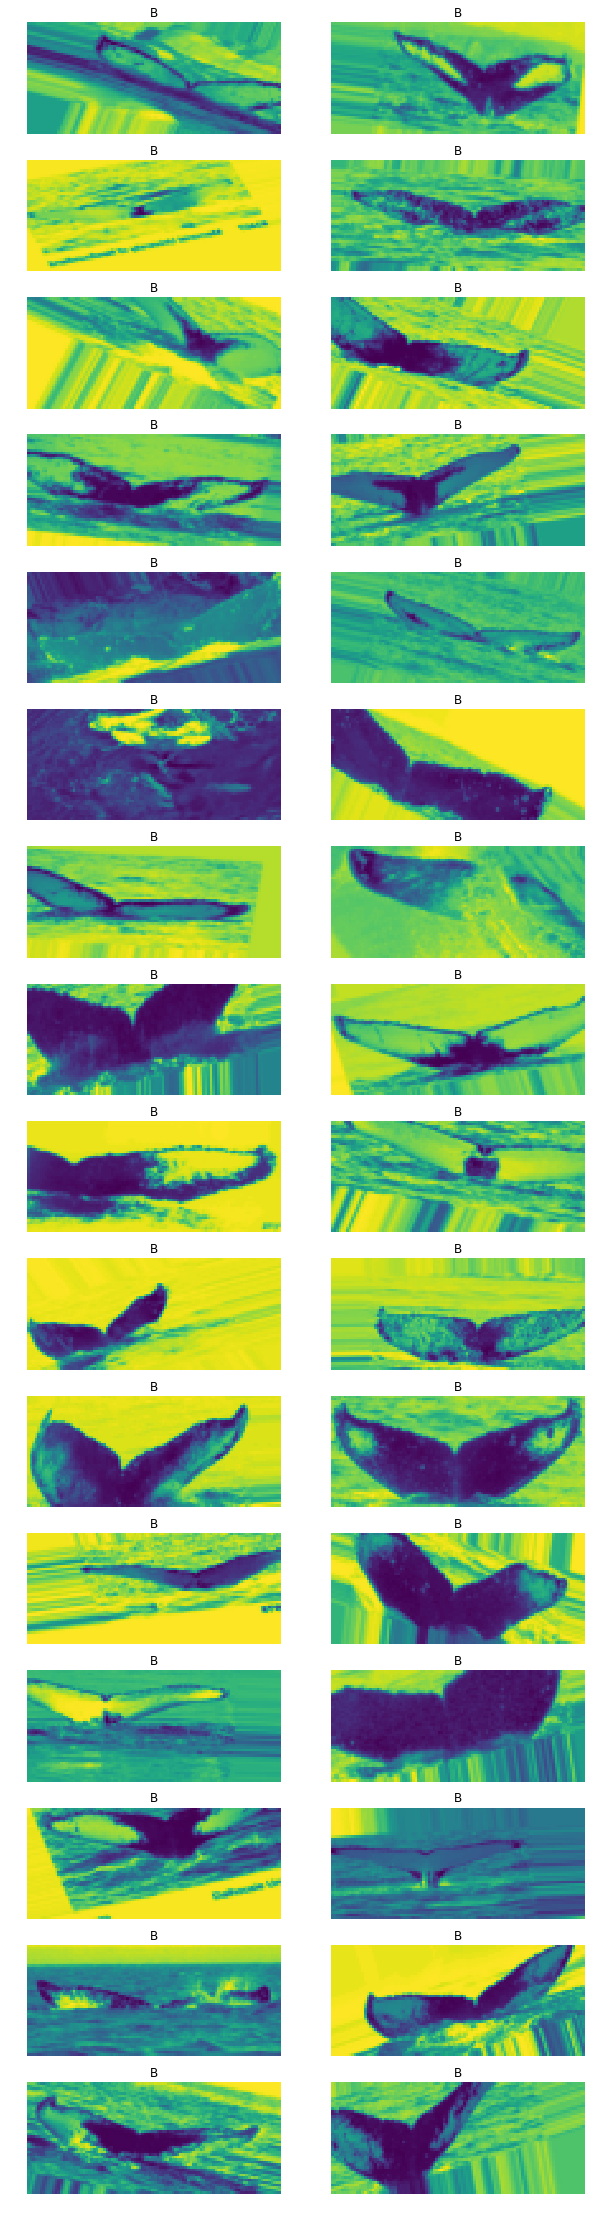

In [15]:
def disp_sample_dataset(dataset1, dataset2, labels, title=None):
    fig = plt.figure(figsize=(10,40))
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    items = random.sample(range(len(labels)), 16)
    for i, item in enumerate(items):
        plt.subplot(16, 2, 2*i + 1)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[item]))
        plt.imshow(dataset1[item])
    for i, item in enumerate(items):
        plt.subplot(16, 2, 2*i + 2)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[item]))
        plt.imshow(dataset2[item])
    plt.show()
    
disp_sample_dataset(x1, x2, y)

### Reserved for testing python 

In [8]:

a = np.asarray([[1,1],[2,2],[3,3]],dtype=float)
print(a)
print(a.shape)
print(np.transpose(a))
print(np.transpose(a).shape)


[[1. 1.]
 [2. 2.]
 [3. 3.]]
(3, 2)
[[1. 2. 3.]
 [1. 2. 3.]]
(2, 3)


In [7]:
x = np.arange(10)
print(x[0:5])
print(x[5:10])

[0 1 2 3 4]
[5 6 7 8 9]


In [27]:
#Make sure the path exist before executing the next steps.
if not os.path.exists(path_train_balanced):
    raise ValueError("Path {} idoes not exist.".format(path_train_balanced) )
     
# get all files' and folders' names in the current directory
_filenames= os.listdir(path_train_balanced) 
_sub_folders = []
# loop through all the files and folders and check whether the current object is a folder or not
    
print(_filenames[0:len(_filenames)])

['w_54fc5b3', 'w_dfcf7fe', 'w_aa70bc3', 'w_f6086ac', 'w_44ef2b8', 'w_68fb716', 'w_2581f2e', 'w_06c470d', 'w_1f2a32a', 'w_2f89dfe', 'w_9a4bd76', 'w_d20befa', 'w_2cdf820', 'w_4057481', 'w_120927e', 'w_898eb3b', 'w_6c9aa21', 'w_3061bdd', 'w_f03ca16', 'w_f8aacbd', 'w_ade77e6', 'w_010a1fa', 'w_7b3f9d1', 'w_23e5a4c', 'w_f0612be', 'w_b9bfd4e', 'w_82bb763', 'w_b6efe77', 'w_175536a', 'w_88b5d47', 'w_bf70a3f', 'w_8a7b9c8', 'w_caf4286', 'w_231a0c8', 'w_49b425b', 'w_1905c66', 'w_d47e2e3', 'w_94da90b', 'w_f4219e3', 'w_e4b5d0b', 'w_db5cc79', 'w_598874c', 'w_daa4876', 'w_e3b236d', 'w_be4d5b8', 'w_ed3bd5b', 'w_19e8a2d', 'w_49c640f', 'w_3aa2073', 'w_5dbe64d', 'w_7abaf06', 'w_8cd6d46', 'w_4a38a9f', 'w_a0149f9', 'w_c39fceb', 'w_91f80eb', 'w_2658649', 'w_9f3e4f4', 'w_7234b3d', 'w_b80d2cb', 'w_89f463f', 'w_2356a6d', 'w_4de83f9', 'w_585e948', 'w_1e31d24', 'w_4a7080a', 'w_099ab25', 'w_bdfd16e', 'w_3f907d6', 'w_04feee0', 'w_91b5f87', 'w_883557a', 'w_ca6a771', 'w_73e1d5b', 'w_6202983', 'w_8a5ff14', 'w_1717a13'

In [71]:
a = np.array([[1,1],[2,2],[3,3]])
b = np.array([[4,4],[5,5],[6,6]])
c = np.array([[7,7],[8,8],[9,9]])
d = np.concatenate((a,b), axis=0)
d = np.concatenate((d,c), axis=0)
arange = np.arange(9)
arange[7]=8
arange[8]=7
print(d)
array = []
array.append(a)
array.append(b)
array.append(c)
e = np.concatenate(array,axis=0)
print(e)
print(e.shape[0])
e = e[arange,:]
e = e[arange,:]
print(e)

[[1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]
 [8 8]
 [9 9]]
[[1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]
 [8 8]
 [9 9]]
9
[[1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]
 [8 8]
 [9 9]]


In [80]:
a = 4250
print((a/2)*2)
print(a%2)
print((a/2)*2+2*(a%2-1))

4250
0
4248


In [10]:
N=20
P=N/2
print(np.arange(P)*2)
print(np.arange(P)*2+1)

[ 0  2  4  6  8 10 12 14 16 18]
[ 1  3  5  7  9 11 13 15 17 19]
